In [ ]:
!pip install pandas numpy openpyxl sentence-transformers transformers nltk spacy scikit-learn xgboost lightgbm pyod torch tensorflow matplotlib seaborn plotly tqdm joblib

In [ ]:
# @title 3. MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [6]:
# @title STEP1 : DATA PREPROCESSING
"""
STEP 1: DATA PREPROCESSING
===========================
Purpose: Load and clean the tender dataset, parse values, create CPV hierarchy

Input: ingested_tenders.xlsx
Output: cleaned_tenders.csv, preprocessing_report.txt
"""

import pandas as pd
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TENDER ANOMALY DETECTION - STEP 1: PREPROCESSING")
print("="*80)

# ==========================================
# 1. LOAD DATA
# ==========================================
print("\n[1/6] Loading dataset...")
input_file = r'/content/drive/MyDrive/ingested_tenders.xlsx'
# input_file = r'/content/large_scale_anomaly_dataset.csv'
df = pd.read_excel(input_file)
print(f"✓ Loaded {len(df):,} tenders with {df.shape[1]} features")

# ==========================================
# 2. PARSE ESTIMATED VALUE
# ==========================================
print("\n[2/6] Parsing estimated values...")

def parse_estimated_value(value_str):
    """
    Parse estimated value from text format to numerical
    Examples:
        "500,000.00 EUR" -> 500000.00
        "1.5 million EUR" -> 1500000.00
        "100,000 - 200,000 EUR" -> 150000.00 (average)
    """
    if pd.isna(value_str):
        return np.nan

    value_str = str(value_str).upper()

    # Remove currency symbols
    value_str = re.sub(r'[€$£¥]', '', value_str)

    # Handle range (take average)
    if '-' in value_str or 'TO' in value_str:
        numbers = re.findall(r'[\d,]+\.?\d*', value_str)
        if len(numbers) >= 2:
            nums = [float(n.replace(',', '')) for n in numbers[:2]]
            value_str = str(sum(nums) / 2)

    # Extract numerical value
    value_str = re.sub(r'[^\d.]', '', value_str)

    try:
        value = float(value_str)
        return value
    except:
        return np.nan

# Apply parsing
df['Estimated_Value_Numeric'] = df['Estimated_Value'].apply(parse_estimated_value)

# Count successful parses
parsed_count = df['Estimated_Value_Numeric'].notna().sum()
parse_rate = (parsed_count / len(df)) * 100
print(f"✓ Successfully parsed {parsed_count:,} values ({parse_rate:.1f}%)")

# ==========================================
# 3. CREATE CPV HIERARCHY FEATURES
# ==========================================
print("\n[3/6] Creating CPV hierarchy features...")

def extract_cpv_levels(cpv_code):
    """
    Extract hierarchical levels from CPV code
    Example: 90721800 -> {level_2: 90, level_4: 9072, level_6: 907218, level_8: 90721800}
    """
    if pd.isna(cpv_code):
        return pd.Series({
            'CPV_Level_2': np.nan,
            'CPV_Level_4': np.nan,
            'CPV_Level_6': np.nan,
            'CPV_Level_8': np.nan
        })

    cpv_str = str(int(cpv_code)).zfill(8)  # Ensure 8 digits

    return pd.Series({
        'CPV_Level_2': int(cpv_str[:2]) if len(cpv_str) >= 2 else np.nan,
        'CPV_Level_4': int(cpv_str[:4]) if len(cpv_str) >= 4 else np.nan,
        'CPV_Level_6': int(cpv_str[:6]) if len(cpv_str) >= 6 else np.nan,
        'CPV_Level_8': int(cpv_str) if len(cpv_str) == 8 else np.nan
    })

# Create CPV features
cpv_features = df['CPV'].apply(extract_cpv_levels)
df = pd.concat([df, cpv_features], axis=1)
print(f"✓ Created 4 CPV hierarchy levels")

# ==========================================
# 4. TEXT PREPROCESSING
# ==========================================
print("\n[4/6] Preprocessing text fields...")

def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""

    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip
    text = text.strip()

    return text

# Clean text columns
text_columns = ['Title', 'Object_Description', 'Award_Criteria', 'Conditions']
for col in text_columns:
    if col in df.columns:
        df[f'{col}_Clean'] = df[col].apply(clean_text)

print(f"✓ Cleaned {len(text_columns)} text columns")

# ==========================================
# 5. CREATE COMBINED TEXT FIELD
# ==========================================
print("\n[5/6] Creating combined text field...")

def combine_text(row):
    """Combine all text fields for comprehensive analysis"""
    parts = []

    if pd.notna(row.get('Title_Clean')):
        parts.append(f"Title: {row['Title_Clean']}")
    if pd.notna(row.get('Object_Description_Clean')):
        parts.append(f"Description: {row['Object_Description_Clean']}")
    if pd.notna(row.get('Award_Criteria_Clean')):
        parts.append(f"Award Criteria: {row['Award_Criteria_Clean']}")
    if pd.notna(row.get('Conditions_Clean')):
        parts.append(f"Conditions: {row['Conditions_Clean']}")

    return " | ".join(parts)

df['Combined_Text'] = df.apply(combine_text, axis=1)
print(f"✓ Created combined text field")

# ==========================================
# 6. CALCULATE ADDITIONAL FEATURES
# ==========================================
print("\n[6/6] Calculating statistical features...")

# Authority frequency (how many tenders per authority)
authority_counts = df['Authority'].value_counts()
df['Authority_Frequency'] = df['Authority'].map(authority_counts)

# CPV frequency
cpv_counts = df['CPV'].value_counts()
df['CPV_Frequency'] = df['CPV'].map(cpv_counts)

# Text statistics
df['Title_Length'] = df['Title_Clean'].str.len()
df['Description_Length'] = df['Object_Description_Clean'].str.len()
df['Combined_Text_Length'] = df['Combined_Text'].str.len()

# Log transform of estimated value (for better distribution)
df['Log_Estimated_Value'] = np.log1p(df['Estimated_Value_Numeric'])

print(f"✓ Created 7 statistical features")

# ==========================================
# 7. HANDLE MISSING VALUES
# ==========================================
print("\n[OPTIONAL] Handling missing values...")

# For CPV: Most tenders have CPV codes (99.17%), so we can drop missing ones
# OR create a special "UNKNOWN" category
original_count = len(df)
df_clean = df.dropna(subset=['CPV'])
dropped_count = original_count - len(df_clean)
print(f"  Dropped {dropped_count} tenders without CPV codes")

# For Estimated_Value_Numeric: Keep NaN for now, models will handle
print(f"  Kept {df_clean['Estimated_Value_Numeric'].isna().sum()} tenders with missing values (to be handled in modeling)")

# ==========================================
# 8. SAVE CLEANED DATA
# ==========================================
print("\n[FINAL] Saving preprocessed data...")

output_file = 'cleaned_tenders.csv'
df_clean.to_csv(output_file, index=False)
print(f"✓ Saved cleaned dataset to: {output_file}")
print(f"  Final dataset: {len(df_clean):,} tenders, {df_clean.shape[1]} features")

# ==========================================
# 9. GENERATE PREPROCESSING REPORT
# ==========================================
report = f"""
{'='*80}
PREPROCESSING REPORT
{'='*80}

DATASET SUMMARY:
- Original records: {original_count:,}
- Final records: {len(df_clean):,}
- Records dropped: {dropped_count}
- Total features: {df_clean.shape[1]}

VALUE PARSING:
- Estimated values parsed: {parsed_count:,} ({parse_rate:.1f}%)
- Failed parses: {len(df) - parsed_count}

CPV HIERARCHY:
- CPV Level 2 (main categories): {df_clean['CPV_Level_2'].nunique()} unique
- CPV Level 4 (subcategories): {df_clean['CPV_Level_4'].nunique()} unique
- CPV Level 6: {df_clean['CPV_Level_6'].nunique()} unique
- CPV Level 8 (full codes): {df_clean['CPV_Level_8'].nunique()} unique

TEXT STATISTICS:
- Average title length: {df_clean['Title_Length'].mean():.0f} characters
- Average description length: {df_clean['Description_Length'].mean():.0f} characters
- Total combined text length: {df_clean['Combined_Text_Length'].mean():.0f} characters

AUTHORITY ANALYSIS:
- Unique authorities: {df_clean['Authority'].nunique()}
- Most active authority: {authority_counts.index[0]} ({authority_counts.iloc[0]} tenders)
- Average tenders per authority: {authority_counts.mean():.1f}

ESTIMATED VALUE STATISTICS:
- Min value: €{df_clean['Estimated_Value_Numeric'].min():,.2f}
- Max value: €{df_clean['Estimated_Value_Numeric'].max():,.2f}
- Mean value: €{df_clean['Estimated_Value_Numeric'].mean():,.2f}
- Median value: €{df_clean['Estimated_Value_Numeric'].median():,.2f}

CREATED FEATURES:
1. Estimated_Value_Numeric (parsed from text)
2-5. CPV_Level_2, CPV_Level_4, CPV_Level_6, CPV_Level_8
6-9. Title_Clean, Object_Description_Clean, Award_Criteria_Clean, Conditions_Clean
10. Combined_Text (all text fields merged)
11. Authority_Frequency
12. CPV_Frequency
13-15. Title_Length, Description_Length, Combined_Text_Length
16. Log_Estimated_Value

{'='*80}
NEXT STEP: Run step2_feature_engineering.py
{'='*80}
"""

with open('preprocessing_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ PREPROCESSING COMPLETE!")
print("="*80)
print(f"\nGenerated files:")
print(f"  1. {output_file} - Cleaned dataset")
print(f"  2. preprocessing_report.txt - Detailed report")
print(f"\nNext step: python step2_feature_engineering.py")


TENDER ANOMALY DETECTION - STEP 1: PREPROCESSING

[1/6] Loading dataset...
✓ Loaded 2,056 tenders with 9 features

[2/6] Parsing estimated values...
✓ Successfully parsed 1,389 values (67.6%)

[3/6] Creating CPV hierarchy features...
✓ Created 4 CPV hierarchy levels

[4/6] Preprocessing text fields...
✓ Cleaned 4 text columns

[5/6] Creating combined text field...
✓ Created combined text field

[6/6] Calculating statistical features...
✓ Created 7 statistical features

[OPTIONAL] Handling missing values...
  Dropped 17 tenders without CPV codes
  Kept 650 tenders with missing values (to be handled in modeling)

[FINAL] Saving preprocessed data...
✓ Saved cleaned dataset to: cleaned_tenders.csv
  Final dataset: 2,039 tenders, 25 features

PREPROCESSING REPORT

DATASET SUMMARY:
- Original records: 2,056
- Final records: 2,039
- Records dropped: 17
- Total features: 25

VALUE PARSING:
- Estimated values parsed: 1,389 (67.6%)
- Failed parses: 667

CPV HIERARCHY:
- CPV Level 2 (main categor

In [10]:
# @title Data Processing for Anomaly Dataset
"""
STEP 1: DATA PREPROCESSING FOR ANOMALY DATASET
================================================
Purpose: Load and clean the anomaly dataset, fix issues, ensure compatibility

Input: tender_anomaly_dataset.csv
Output: cleaned_anomaly_tenders.csv, preprocessing_report.txt
"""

import pandas as pd
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ANOMALY DATASET PREPROCESSING")
print("="*80)

# ==========================================
# 1. LOAD ANOMALY DATASET
# ==========================================
print("\n[1/6] Loading anomaly dataset...")
input_file = r'/tender_anomaly_dataset.csv'  # Your generated CSV file
df = pd.read_csv(input_file)

# Check if Is_Anomaly column exists (label for evaluation)
if 'Is_Anomaly' not in df.columns:
    print("⚠ Warning: Is_Anomaly column not found, creating placeholder...")
    df['Is_Anomaly'] = 0

print(f"✓ Loaded {len(df):,} tenders with {df.shape[1]} features")
print(f"  Anomaly labels: {df['Is_Anomaly'].sum():,} anomalies, {len(df) - df['Is_Anomaly'].sum():,} normal")

# ==========================================
# 2. FIX DATA ISSUES
# ==========================================
print("\n[2/6] Fixing data issues...")

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fix missing Word_Count column
if 'Word_Count' not in df.columns:
    print("  Creating Word_Count column...")
    # Estimate word count from Conditions if available, otherwise from Combined_Text
    if 'Conditions' in df.columns:
        df['Word_Count'] = df['Conditions'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    else:
        df['Word_Count'] = 100  # Default value

# Ensure all required columns exist
required_columns = ['Title', 'Authority', 'Object_Description', 'CPV',
                    'Estimated_Value', 'Award_Criteria', 'Conditions', 'Word_Count']

for col in required_columns:
    if col not in df.columns:
        print(f"  ⚠ Warning: {col} column missing, creating empty...")
        df[col] = ""

print("✓ Fixed data issues")

# ==========================================
# 3. PARSE ESTIMATED VALUE
# ==========================================
print("\n[3/6] Parsing estimated values...")

def parse_estimated_value(value):
    """
    Parse estimated value, handling various formats including anomalies
    """
    if pd.isna(value):
        return np.nan

    # Convert to string
    value_str = str(value).upper()

    # Handle infinite already done
    if value_str == 'INF' or value_str == '-INF':
        return np.nan

    # Remove non-numeric characters except decimal point and minus
    value_str = re.sub(r'[^\d.\-]', '', value_str)

    # Handle negative values
    if value_str.startswith('-'):
        try:
            return -float(value_str[1:])
        except:
            return np.nan

    try:
        if value_str == '':
            return np.nan
        return float(value_str)
    except:
        return np.nan

# Apply parsing
df['Estimated_Value_Numeric'] = df['Estimated_Value'].apply(parse_estimated_value)

# Count successful parses
parsed_count = df['Estimated_Value_Numeric'].notna().sum()
parse_rate = (parsed_count / len(df)) * 100
print(f"✓ Successfully parsed {parsed_count:,} values ({parse_rate:.1f}%)")

# ==========================================
# 4. CREATE CPV HIERARCHY FEATURES
# ==========================================
print("\n[4/6] Creating CPV hierarchy features...")

def extract_cpv_levels(cpv_code):
    """
    Extract hierarchical levels from CPV code, handle anomalies
    """
    if pd.isna(cpv_code):
        return pd.Series({
            'CPV_Level_2': np.nan,
            'CPV_Level_4': np.nan,
            'CPV_Level_6': np.nan,
            'CPV_Level_8': np.nan
        })

    cpv_str = str(cpv_code)

    # Clean CPV string
    cpv_str = re.sub(r'[^0-9]', '', cpv_str)

    # Pad with zeros if less than 8 digits
    if len(cpv_str) < 8:
        cpv_str = cpv_str.ljust(8, '0')
    elif len(cpv_str) > 8:
        cpv_str = cpv_str[:8]  # Truncate if too long

    try:
        return pd.Series({
            'CPV_Level_2': int(cpv_str[:2]) if cpv_str[:2].isdigit() else np.nan,
            'CPV_Level_4': int(cpv_str[:4]) if cpv_str[:4].isdigit() else np.nan,
            'CPV_Level_6': int(cpv_str[:6]) if cpv_str[:6].isdigit() else np.nan,
            'CPV_Level_8': int(cpv_str) if cpv_str.isdigit() else np.nan
        })
    except:
        return pd.Series({
            'CPV_Level_2': np.nan,
            'CPV_Level_4': np.nan,
            'CPV_Level_6': np.nan,
            'CPV_Level_8': np.nan
        })

# Create CPV features
cpv_features = df['CPV'].apply(extract_cpv_levels)
df = pd.concat([df, cpv_features], axis=1)
print(f"✓ Created 4 CPV hierarchy levels")

# ==========================================
# 5. TEXT PREPROCESSING
# ==========================================
print("\n[5/6] Preprocessing text fields...")

def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""

    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip
    text = text.strip()

    return text

# Clean text columns
text_columns = ['Title', 'Object_Description', 'Award_Criteria', 'Conditions']
for col in text_columns:
    if col in df.columns:
        df[f'{col}_Clean'] = df[col].apply(clean_text)

print(f"✓ Cleaned {len(text_columns)} text columns")

# ==========================================
# 6. CREATE COMBINED TEXT FIELD
# ==========================================
print("\n[6/6] Creating combined text field...")

def combine_text(row):
    """Combine all text fields for comprehensive analysis"""
    parts = []

    if pd.notna(row.get('Title_Clean')):
        parts.append(f"Title: {row['Title_Clean']}")
    if pd.notna(row.get('Object_Description_Clean')):
        parts.append(f"Description: {row['Object_Description_Clean']}")
    if pd.notna(row.get('Award_Criteria_Clean')):
        parts.append(f"Award Criteria: {row['Award_Criteria_Clean']}")
    if pd.notna(row.get('Conditions_Clean')):
        parts.append(f"Conditions: {row['Conditions_Clean']}")

    return " | ".join(parts)

df['Combined_Text'] = df.apply(combine_text, axis=1)
print(f"✓ Created combined text field")

# ==========================================
# 7. CALCULATE ADDITIONAL FEATURES
# ==========================================
print("\n[7/7] Calculating statistical features...")

# Authority frequency (how many tenders per authority)
if 'Authority' in df.columns:
    authority_counts = df['Authority'].fillna('Unknown').value_counts()
    df['Authority_Frequency'] = df['Authority'].fillna('Unknown').map(authority_counts)
else:
    df['Authority_Frequency'] = 1

# CPV frequency
if 'CPV' in df.columns:
    cpv_counts = df['CPV'].fillna('00000000').value_counts()
    df['CPV_Frequency'] = df['CPV'].fillna('00000000').map(cpv_counts)
else:
    df['CPV_Frequency'] = 1

# Text statistics
df['Title_Length'] = df['Title_Clean'].str.len()
df['Description_Length'] = df['Object_Description_Clean'].str.len()
df['Combined_Text_Length'] = df['Combined_Text'].str.len()

# Log transform of estimated value (for better distribution)
df['Log_Estimated_Value'] = np.log1p(df['Estimated_Value_Numeric'].clip(lower=0))

print(f"✓ Created statistical features")

# ==========================================
# 8. HANDLE MISSING VALUES
# ==========================================
print("\n[OPTIONAL] Handling missing values...")

original_count = len(df)

# For CPV: Replace missing with placeholder
if 'CPV' in df.columns:
    df['CPV'] = df['CPV'].fillna('99999999')
    print(f"  Filled {df['CPV'].isna().sum()} missing CPV codes with placeholder")

# For other critical columns, fill with appropriate values
for col in ['CPV_Level_2', 'CPV_Level_4', 'CPV_Level_6', 'CPV_Level_8']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print(f"  Kept {df['Estimated_Value_Numeric'].isna().sum()} tenders with missing values")

# ==========================================
# 9. SAVE CLEANED DATA
# ==========================================
print("\n[FINAL] Saving preprocessed anomaly data...")

output_file = 'cleaned_anomaly_tenders.csv'
df.to_csv(output_file, index=False)
print(f"✓ Saved cleaned anomaly dataset to: {output_file}")
print(f"  Final dataset: {len(df):,} tenders, {df.shape[1]} features")

# ==========================================
# 10. GENERATE PREPROCESSING REPORT
# ==========================================
report = f"""
{'='*80}
ANOMALY DATASET PREPROCESSING REPORT
{'='*80}

DATASET SUMMARY:
- Original records: {original_count:,}
- Final records: {len(df):,}
- Total features: {df.shape[1]}
- Anomaly labels: {df['Is_Anomaly'].sum():,} ({df['Is_Anomaly'].mean()*100:.1f}%)

VALUE PARSING:
- Estimated values parsed: {parsed_count:,} ({parse_rate:.1f}%)
- Failed parses: {len(df) - parsed_count}

CPV HIERARCHY:
- CPV Level 2 (main categories): {df['CPV_Level_2'].nunique()} unique
- CPV Level 4 (subcategories): {df['CPV_Level_4'].nunique()} unique
- Valid CPV codes: {df['CPV_Level_8'].notna().sum():,}

TEXT STATISTICS:
- Average title length: {df['Title_Length'].mean():.0f} characters
- Average description length: {df['Description_Length'].mean():.0f} characters
- Empty titles: {(df['Title_Clean'] == '').sum():,}

ANOMALY BREAKDOWN:
- Total anomalies: {df['Is_Anomaly'].sum():,}
- Anomalies with invalid CPV: {((df['CPV_Level_8'].isna()) & (df['Is_Anomaly'] == 1)).sum():,}
- Anomalies with missing values: {(df['Estimated_Value_Numeric'].isna() & (df['Is_Anomaly'] == 1)).sum():,}
- Anomalies with empty titles: {((df['Title_Clean'] == '') & (df['Is_Anomaly'] == 1)).sum():,}

CREATED FEATURES:
1. Estimated_Value_Numeric
2-5. CPV_Level_2, CPV_Level_4, CPV_Level_6, CPV_Level_8
6-9. Title_Clean, Object_Description_Clean, Award_Criteria_Clean, Conditions_Clean
10. Combined_Text
11. Authority_Frequency
12. CPV_Frequency
13-15. Title_Length, Description_Length, Combined_Text_Length
16. Log_Estimated_Value
17. Is_Anomaly (ground truth label)

{'='*80}
NEXT STEP: Run feature_engineering.py on cleaned_anomaly_tenders.csv
{'='*80}
"""

with open('anomaly_preprocessing_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ ANOMALY PREPROCESSING COMPLETE!")
print("="*80)

ANOMALY DATASET PREPROCESSING

[1/6] Loading anomaly dataset...
✓ Loaded 200 tenders with 14 features
  Anomaly labels: 100.0 anomalies, 100.0 normal

[2/6] Fixing data issues...
✓ Fixed data issues

[3/6] Parsing estimated values...
✓ Successfully parsed 103 values (51.5%)

[4/6] Creating CPV hierarchy features...
✓ Created 4 CPV hierarchy levels

[5/6] Preprocessing text fields...
✓ Cleaned 4 text columns

[6/6] Creating combined text field...
✓ Created combined text field

[7/7] Calculating statistical features...
✓ Created statistical features

[OPTIONAL] Handling missing values...
  Filled 0 missing CPV codes with placeholder
  Kept 97 tenders with missing values

[FINAL] Saving preprocessed anomaly data...
✓ Saved cleaned anomaly dataset to: cleaned_anomaly_tenders.csv
  Final dataset: 200 tenders, 29 features

ANOMALY DATASET PREPROCESSING REPORT

DATASET SUMMARY:
- Original records: 200
- Final records: 200
- Total features: 29
- Anomaly labels: 100.0 (51.5%)

VALUE PARSING:
- 

In [5]:
# @title Data Pecessing for Large scale anomaly
"""
PREPROCESSING FOR LARGE-SCALE ANOMALY DATASET
==============================================
"""
import pandas as pd
import numpy as np
import re

print("="*80)
print("PREPROCESSING LARGE-SCALE ANOMALY DATASET")
print("="*80)

# Load the dataset
df = pd.read_csv('large_scale_anomaly_dataset.csv')
print(f"Loaded {len(df):,} records")

# Keep the anomaly labels
if 'Is_Anomaly' in df.columns:
    print(f"Anomaly labels found: {df['Is_Anomaly'].sum():,} anomalies")
    df.rename(columns={'Is_Anomaly': 'Ground_Truth_Anomaly'}, inplace=True)

# Parse estimated values
def robust_value_parser(value):
    if pd.isna(value):
        return np.nan

    try:
        # Handle string values
        if isinstance(value, str):
            # Remove currency symbols and text
            value = re.sub(r'[^\d.]', '', value)
            if value == '':
                return np.nan

        # Convert to float
        val = float(value)

        # Check for extreme values
        if abs(val) > 1e9:  # Over 1 billion
            return np.nan
        if val == 0:  # Zero value
            return 0  # Keep as is (might be anomaly)

        return val
    except:
        return np.nan

df['Estimated_Value_Numeric'] = df['Estimated_Value'].apply(robust_value_parser)

# Create CPV hierarchy
def create_cpv_hierarchy(cpv):
    if pd.isna(cpv):
        return pd.Series([np.nan, np.nan, np.nan, np.nan])

    cpv_str = str(cpv)
    cpv_str = re.sub(r'[^0-9]', '', cpv_str)

    if len(cpv_str) < 8:
        cpv_str = cpv_str.ljust(8, '0')

    try:
        return pd.Series([
            int(cpv_str[:2]) if cpv_str[:2].isdigit() else 99,
            int(cpv_str[:4]) if cpv_str[:4].isdigit() else 9999,
            int(cpv_str[:6]) if cpv_str[:6].isdigit() else 999999,
            int(cpv_str) if cpv_str.isdigit() else 99999999
        ])
    except:
        return pd.Series([99, 9999, 999999, 99999999])

cpv_features = df['CPV'].apply(create_cpv_hierarchy)
cpv_features.columns = ['CPV_Level_2', 'CPV_Level_4', 'CPV_Level_6', 'CPV_Level_8']
df = pd.concat([df, cpv_features], axis=1)

# Clean text fields
text_cols = ['Title', 'Object_Description', 'Award_Criteria', 'Conditions']
for col in text_cols:
    if col in df.columns:
        df[f'{col}_Clean'] = df[col].fillna('').astype(str).apply(
            lambda x: re.sub(r'\s+', ' ', x).strip()
        )

# Create combined text
def combine_text(row):
    parts = []
    for col in text_cols:
        clean_col = f'{col}_Clean'
        if clean_col in df.columns and row[clean_col]:
            parts.append(f"{col}: {row[clean_col]}")
    return " | ".join(parts)

df['Combined_Text'] = df.apply(combine_text, axis=1)

# Calculate features
df['Title_Length'] = df['Title_Clean'].str.len()
df['Description_Length'] = df['Object_Description_Clean'].str.len()
df['Combined_Text_Length'] = df['Combined_Text'].str.len()

# Authority frequency
if 'Authority' in df.columns:
    auth_counts = df['Authority'].value_counts()
    df['Authority_Frequency'] = df['Authority'].map(auth_counts)

# CPV frequency
if 'CPV' in df.columns:
    cpv_counts = df['CPV'].value_counts()
    df['CPV_Frequency'] = df['CPV'].map(cpv_counts)

# Log value
df['Log_Estimated_Value'] = np.log1p(df['Estimated_Value_Numeric'].clip(lower=0))

# Save
output_file = 'cleaned_large_scale_tenders.csv'
df.to_csv(output_file, index=False)

print(f"\nSaved to: {output_file}")
print(f"Records: {len(df):,}")
print(f"Features: {df.shape[1]}")
print(f"Anomalies in dataset: {df['Ground_Truth_Anomaly'].sum():,}")
print("\n" + "="*80)

PREPROCESSING LARGE-SCALE ANOMALY DATASET
Loaded 1,000 records
Anomaly labels found: 500 anomalies

Saved to: cleaned_large_scale_tenders.csv
Records: 1,000
Features: 31
Anomalies in dataset: 500



In [8]:
# @title STEP 2 : FEATURE ENGINEERING

"""
STEP 2: FEATURE ENGINEERING
============================
Purpose: Generate text embeddings and engineer features for anomaly detection

Input: cleaned_tenders.csv
Output: features.pkl, feature_engineering_report.txt
"""

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TENDER ANOMALY DETECTION - STEP 2: FEATURE ENGINEERING")
print("="*80)

# ==========================================
# 1. LOAD CLEANED DATA
# ==========================================
print("\n[1/5] Loading cleaned dataset...")
df = pd.read_csv('cleaned_tenders.csv')
# df = pd.read_csv('cleaned_anomaly_tenders.csv')
# df = pd.read_csv('cleaned_large_scale_tenders.csv')
print(f"✓ Loaded {len(df):,} tenders")

# ==========================================
# 2. GENERATE TEXT EMBEDDINGS
# ==========================================
print("\n[2/5] Generating text embeddings (this may take a few minutes)...")
print("  Loading Sentence-BERT model...")

# Choose embedding model
# 'all-MiniLM-L6-v2': Fast, 384 dimensions, good quality
# 'all-mpnet-base-v2': Slower, 768 dimensions, better quality
model_name = 'all-mpnet-base-v2'

try:
    model = SentenceTransformer(model_name)
    print(f"  ✓ Loaded model: {model_name}")
except Exception as e:
    print(f"  ✗ Failed to load model: {e}")
    print("  Installing sentence-transformers...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'sentence-transformers'])
    model = SentenceTransformer(model_name)
    print(f"  ✓ Loaded model: {model_name}")

# Generate embeddings for combined text
print("  Encoding tender descriptions...")
texts = df['Combined_Text'].fillna("").tolist()

# Process in batches for better memory management
batch_size = 32
embeddings = model.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"  ✓ Generated embeddings: shape {embeddings.shape}")

# Create embedding dataframe
embedding_cols = [f'embedding_{i}' for i in range(embeddings.shape[1])]
df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols)

# ==========================================
# 3. CREATE NUMERICAL FEATURES
# ==========================================
print("\n[3/5] Creating numerical features...")

numerical_features = pd.DataFrame()

# 3.1 Value-based features
numerical_features['Estimated_Value'] = df['Estimated_Value_Numeric'].fillna(df['Estimated_Value_Numeric'].median())
numerical_features['Log_Estimated_Value'] = df['Log_Estimated_Value'].fillna(0)

# 3.2 CPV-based value normalization (Z-score within each CPV category)
print("  Computing CPV-normalized values...")
df['Value_Z_Score_CPV'] = df.groupby('CPV_Level_2')['Estimated_Value_Numeric'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
).fillna(0)
numerical_features['Value_Z_Score_CPV'] = df['Value_Z_Score_CPV']

# 3.3 Text length features
numerical_features['Title_Length'] = df['Title_Length'].fillna(0)
numerical_features['Description_Length'] = df['Description_Length'].fillna(0)
numerical_features['Word_Count'] = df['Word_Count'].fillna(0)
numerical_features['Combined_Text_Length'] = df['Combined_Text_Length'].fillna(0)

# 3.4 Frequency features
numerical_features['Authority_Frequency'] = df['Authority_Frequency'].fillna(1)
numerical_features['CPV_Frequency'] = df['CPV_Frequency'].fillna(1)

# 3.5 CPV hierarchy features
numerical_features['CPV_Level_2'] = df['CPV_Level_2'].fillna(0)
numerical_features['CPV_Level_4'] = df['CPV_Level_4'].fillna(0)

# 3.6 Derived features
# Value per word (indicates if high-value tender has suspiciously short description)
numerical_features['Value_Per_Word'] = (
    numerical_features['Estimated_Value'] / (numerical_features['Word_Count'] + 1)
)

# Description complexity ratio
numerical_features['Complexity_Ratio'] = (
    numerical_features['Description_Length'] / (numerical_features['Word_Count'] + 1)
)

print(f"  ✓ Created {numerical_features.shape[1]} numerical features")

# ==========================================
# 4. NORMALIZE NUMERICAL FEATURES
# ==========================================
print("\n[4/5] Normalizing features...")

scaler = StandardScaler()
numerical_features_scaled = pd.DataFrame(
    scaler.fit_transform(numerical_features),
    columns=numerical_features.columns
)

print(f"  ✓ Normalized {numerical_features_scaled.shape[1]} features")

# ==========================================
# 5. COMBINE ALL FEATURES
# ==========================================
print("\n[5/5] Combining all features...")

# Combine embeddings + numerical features
feature_matrix = pd.concat([
    df_embeddings,
    numerical_features_scaled
], axis=1)

print(f"  ✓ Final feature matrix: {feature_matrix.shape}")
print(f"    - Text embeddings: {df_embeddings.shape[1]} dimensions")
print(f"    - Numerical features: {numerical_features_scaled.shape[1]} features")

# ==========================================
# 6. SAVE FEATURES
# ==========================================
print("\n[FINAL] Saving engineered features...")

# Save feature matrix
with open('features.pkl', 'wb') as f:
    pickle.dump({
        'feature_matrix': feature_matrix,
        'embedding_columns': embedding_cols,
        'numerical_columns': numerical_features.columns.tolist(),
        'scaler': scaler,
        'model_name': model_name,
        'tender_ids': df.index.tolist()
    }, f)

print(f"✓ Saved features to: features.pkl")

# Also save as CSV for inspection (sample)
feature_matrix.head(100).to_csv('features_sample.csv', index=False)
print(f"✓ Saved sample features to: features_sample.csv")

# ==========================================
# 7. GENERATE FEATURE ENGINEERING REPORT
# ==========================================
report = f"""
{'='*80}
FEATURE ENGINEERING REPORT
{'='*80}

DATASET:
- Total tenders: {len(df):,}
- Total features generated: {feature_matrix.shape[1]}

TEXT EMBEDDINGS:
- Model: {model_name}
- Embedding dimensions: {embeddings.shape[1]}
- Total embeddings: {len(embeddings):,}

NUMERICAL FEATURES ({numerical_features.shape[1]}):
1. Estimated_Value (median imputation)
2. Log_Estimated_Value
3. Value_Z_Score_CPV (normalized within CPV category)
4. Title_Length
5. Description_Length
6. Word_Count
7. Combined_Text_Length
8. Authority_Frequency
9. CPV_Frequency
10. CPV_Level_2
11. CPV_Level_4
12. Value_Per_Word (derived)
13. Complexity_Ratio (derived)

FEATURE STATISTICS:
- Estimated Value Range: €{numerical_features['Estimated_Value'].min():,.0f} - €{numerical_features['Estimated_Value'].max():,.0f}
- Average Word Count: {numerical_features['Word_Count'].mean():.0f}
- Average Authority Frequency: {numerical_features['Authority_Frequency'].mean():.1f}
- Unique CPV Level 2 Categories: {numerical_features['CPV_Level_2'].nunique()}

NORMALIZATION:
- Method: StandardScaler (zero mean, unit variance)
- Applied to: All numerical features
- Embeddings: Pre-normalized by Sentence-BERT

DATA QUALITY:
- Missing values handled: Yes (median imputation)
- Outliers: Preserved (to be detected by anomaly models)

{'='*80}
NEXT STEP: Run step3_anomaly_models.py
{'='*80}
"""

with open('feature_engineering_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"\nGenerated files:")
print(f"  1. features.pkl - Complete feature matrix")
print(f"  2. features_sample.csv - Sample features (first 100)")
print(f"  3. feature_engineering_report.txt - Detailed report")
print(f"\nNext step: python step3_anomaly_models.py")


TENDER ANOMALY DETECTION - STEP 2: FEATURE ENGINEERING

[1/5] Loading cleaned dataset...
✓ Loaded 2,039 tenders

[2/5] Generating text embeddings (this may take a few minutes)...
  Loading Sentence-BERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  ✓ Loaded model: all-mpnet-base-v2
  Encoding tender descriptions...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

  ✓ Generated embeddings: shape (2039, 768)

[3/5] Creating numerical features...
  Computing CPV-normalized values...
  ✓ Created 13 numerical features

[4/5] Normalizing features...
  ✓ Normalized 13 features

[5/5] Combining all features...
  ✓ Final feature matrix: (2039, 781)
    - Text embeddings: 768 dimensions
    - Numerical features: 13 features

[FINAL] Saving engineered features...
✓ Saved features to: features.pkl
✓ Saved sample features to: features_sample.csv

FEATURE ENGINEERING REPORT

DATASET:
- Total tenders: 2,039
- Total features generated: 781

TEXT EMBEDDINGS:
- Model: all-mpnet-base-v2
- Embedding dimensions: 768
- Total embeddings: 2,039

NUMERICAL FEATURES (13):
1. Estimated_Value (median imputation)
2. Log_Estimated_Value
3. Value_Z_Score_CPV (normalized within CPV category)
4. Title_Length
5. Description_Length
6. Word_Count
7. Combined_Text_Length
8. Authority_Frequency
9. CPV_Frequency
10. CPV_Level_2
11. CPV_Level_4
12. Value_Per_Word (derived)
13. Comple

In [9]:
# @title STEP 3: ANOMALY DETECTION MODELS
"""
STEP 3: ANOMALY DETECTION MODELS
=================================
Purpose: Train multiple anomaly detection models

Input: features.pkl, cleaned_tenders.csv
Output: models/*.pkl, anomaly_scores.csv
"""

import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

print("="*80)
print("TENDER ANOMALY DETECTION - STEP 3: TRAINING MODELS")
print("="*80)

# Create models directory
Path('models').mkdir(exist_ok=True)

# ==========================================
# 1. LOAD DATA AND FEATURES
# ==========================================
print("\n[1/7] Loading data and features...")

# Load cleaned data
df = pd.read_csv('cleaned_tenders.csv')

# Load features
with open('features.pkl', 'rb') as f:
    feature_data = pickle.load(f)
    X = feature_data['feature_matrix']
    embedding_cols = feature_data['embedding_columns']
    numerical_cols = feature_data['numerical_columns']

print(f"✓ Loaded {len(df):,} tenders with {X.shape[1]} features")

# Separate feature types
X_embeddings = X[embedding_cols]
X_numerical = X[numerical_cols]
X_combined = X  # All features

# ==========================================
# 2. MODEL 1: ISOLATION FOREST
# ==========================================
print("\n[2/7] Training Isolation Forest...")
print("  Purpose: General-purpose outlier detection")

# Hyperparameters
contamination = 0.05  # Expected proportion of anomalies (5%)
n_estimators = 100
random_state = 42

iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=n_estimators,
    random_state=random_state,
    n_jobs=-1,
    verbose=0
)

# Train on combined features
iso_forest.fit(X_combined)

# Get anomaly scores (lower = more anomalous)
iso_scores_raw = iso_forest.decision_function(X_combined)
# Normalize to 0-1 (1 = most anomalous)
iso_scores = 1 - MinMaxScaler().fit_transform(iso_scores_raw.reshape(-1, 1)).flatten()

# Get predictions (-1 = anomaly, 1 = normal)
iso_predictions = iso_forest.predict(X_combined)

print(f"  ✓ Trained Isolation Forest")
print(f"    Anomalies detected: {(iso_predictions == -1).sum()} ({(iso_predictions == -1).sum()/len(df)*100:.1f}%)")

# Save model
with open('models/isolation_forest.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)

# ==========================================
# 3. MODEL 2: LOCAL OUTLIER FACTOR (LOF)
# ==========================================
print("\n[3/7] Training Local Outlier Factor...")
print("  Purpose: Density-based local anomaly detection")

# Hyperparameters
n_neighbors = 20
contamination_lof = 0.05

lof = LocalOutlierFactor(
    n_neighbors=n_neighbors,
    contamination=contamination_lof,
    novelty=True,  # Enable predict for new data
    n_jobs=-1
)

# Train on combined features
lof.fit(X_combined)

# Get anomaly scores
lof_scores_raw = lof.decision_function(X_combined)
# Normalize to 0-1 (1 = most anomalous)
lof_scores = 1 - MinMaxScaler().fit_transform(lof_scores_raw.reshape(-1, 1)).flatten()

# Get predictions
lof_predictions = lof.predict(X_combined)

print(f"  ✓ Trained LOF")
print(f"    Anomalies detected: {(lof_predictions == -1).sum()} ({(lof_predictions == -1).sum()/len(df)*100:.1f}%)")

# Save model
with open('models/lof.pkl', 'wb') as f:
    pickle.dump(lof, f)

# ==========================================
# 4. MODEL 3: ONE-CLASS SVM
# ==========================================
print("\n[4/7] Training One-Class SVM...")
print("  Purpose: Robust boundary-based detection")

# Hyperparameters
nu = 0.05  # Upper bound on fraction of anomalies
kernel = 'rbf'
gamma = 'scale'

# Note: One-Class SVM is slow on large datasets
# For 2000+ samples, we'll use a sample for training
if len(X_combined) > 1500:
    print(f"  Note: Using 1500 samples for training (dataset has {len(X_combined)} samples)")
    sample_idx = np.random.choice(len(X_combined), 1500, replace=False)
    X_sample = X_combined.iloc[sample_idx]
else:
    X_sample = X_combined

oc_svm = OneClassSVM(
    nu=nu,
    kernel=kernel,
    gamma=gamma
)

# Train
print("  Training (this may take a minute)...")
oc_svm.fit(X_sample)

# Get anomaly scores for full dataset
oc_svm_scores_raw = oc_svm.decision_function(X_combined)
# Normalize to 0-1
oc_svm_scores = 1 - MinMaxScaler().fit_transform(oc_svm_scores_raw.reshape(-1, 1)).flatten()

# Get predictions
oc_svm_predictions = oc_svm.predict(X_combined)

print(f"  ✓ Trained One-Class SVM")
print(f"    Anomalies detected: {(oc_svm_predictions == -1).sum()} ({(oc_svm_predictions == -1).sum()/len(df)*100:.1f}%)")

# Save model
with open('models/one_class_svm.pkl', 'wb') as f:
    pickle.dump(oc_svm, f)

# ==========================================
# 5. MODEL 4: AUTOENCODER (OPTIONAL)
# ==========================================
print("\n[5/7] Training Autoencoder...")
print("  Purpose: Deep learning-based reconstruction error detection")

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

    # Define Autoencoder architecture
    class Autoencoder(nn.Module):
        def __init__(self, input_dim):
            super(Autoencoder, self).__init__()

            # Encoder
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU()
            )

            # Decoder
            self.decoder = nn.Sequential(
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, input_dim)
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    # Prepare data
    X_tensor = torch.FloatTensor(X_embeddings.values)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    input_dim = X_embeddings.shape[1]
    autoencoder = Autoencoder(input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Train
    num_epochs = 50
    autoencoder.train()

    print(f"  Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            batch_data = batch[0]

            # Forward pass
            reconstructed = autoencoder(batch_data)
            loss = criterion(reconstructed, batch_data)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.6f}")

    # Get reconstruction errors as anomaly scores
    autoencoder.eval()
    with torch.no_grad():
        reconstructed = autoencoder(X_tensor)
        reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()

    # Normalize to 0-1
    ae_scores = MinMaxScaler().fit_transform(reconstruction_errors.reshape(-1, 1)).flatten()

    print(f"  ✓ Trained Autoencoder")

    # Save model
    torch.save(autoencoder.state_dict(), 'models/autoencoder.pth')

    ae_available = True

except ImportError:
    print("  ⚠ PyTorch not available, skipping Autoencoder")
    print("    Install with: pip install torch")
    ae_scores = np.zeros(len(df))  # Placeholder
    ae_available = False

# ==========================================
# 6. MODEL 5: STATISTICAL OUTLIER DETECTION
# ==========================================
print("\n[6/7] Computing statistical outliers...")
print("  Purpose: CPV-specific value anomalies")

# Calculate Z-scores within each CPV category for estimated values
df['Value_Statistical_Score'] = 0.0

for cpv in df['CPV_Level_2'].unique():
    mask = df['CPV_Level_2'] == cpv
    values = df.loc[mask, 'Estimated_Value_Numeric']

    if len(values) > 3 and values.std() > 0:  # Need minimum samples
        z_scores = np.abs((values - values.mean()) / values.std())
        df.loc[mask, 'Value_Statistical_Score'] = z_scores

# Normalize to 0-1
stat_scores = MinMaxScaler().fit_transform(
    df['Value_Statistical_Score'].values.reshape(-1, 1)
).flatten()

# Count extreme outliers (|Z| > 3)
extreme_outliers = (df['Value_Statistical_Score'] > 3).sum()
print(f"  ✓ Computed statistical outliers")
print(f"    Extreme outliers (|Z| > 3): {extreme_outliers} ({extreme_outliers/len(df)*100:.1f}%)")

# ==========================================
# 7. SAVE ALL SCORES
# ==========================================
print("\n[7/7] Saving anomaly scores...")

# Create results dataframe
results = pd.DataFrame({
    'Tender_Index': df.index,
    'Title': df['Title'],
    'Authority': df['Authority'],
    'CPV': df['CPV'],
    'Estimated_Value': df['Estimated_Value_Numeric'],

    # Individual model scores
    'IsolationForest_Score': iso_scores,
    'LOF_Score': lof_scores,
    'OneClassSVM_Score': oc_svm_scores,
    'Autoencoder_Score': ae_scores if ae_available else 0,
    'Statistical_Score': stat_scores,

    # Predictions
    'IsolationForest_Anomaly': (iso_predictions == -1).astype(int),
    'LOF_Anomaly': (lof_predictions == -1).astype(int),
    'OneClassSVM_Anomaly': (oc_svm_predictions == -1).astype(int),
})

# Save
results.to_csv('anomaly_scores.csv', index=False)
print(f"✓ Saved anomaly scores to: anomaly_scores.csv")

# ==========================================
# 8. GENERATE TRAINING REPORT
# ==========================================
report = f"""
{'='*80}
ANOMALY DETECTION MODELS - TRAINING REPORT
{'='*80}

DATASET:
- Total tenders: {len(df):,}
- Feature dimensions: {X.shape[1]}

MODELS TRAINED:

1. ISOLATION FOREST
   - Contamination: {contamination} ({contamination*100:.0f}%)
   - Estimators: {n_estimators}
   - Anomalies flagged: {(iso_predictions == -1).sum()} ({(iso_predictions == -1).sum()/len(df)*100:.1f}%)
   - Score range: [{iso_scores.min():.3f}, {iso_scores.max():.3f}]

2. LOCAL OUTLIER FACTOR (LOF)
   - Neighbors: {n_neighbors}
   - Contamination: {contamination_lof} ({contamination_lof*100:.0f}%)
   - Anomalies flagged: {(lof_predictions == -1).sum()} ({(lof_predictions == -1).sum()/len(df)*100:.1f}%)
   - Score range: [{lof_scores.min():.3f}, {lof_scores.max():.3f}]

3. ONE-CLASS SVM
   - Nu: {nu} ({nu*100:.0f}%)
   - Kernel: {kernel}
   - Anomalies flagged: {(oc_svm_predictions == -1).sum()} ({(oc_svm_predictions == -1).sum()/len(df)*100:.1f}%)
   - Score range: [{oc_svm_scores.min():.3f}, {oc_svm_scores.max():.3f}]

4. AUTOENCODER
   - Status: {'Trained' if ae_available else 'Skipped (PyTorch not available)'}
   - Architecture: {input_dim if ae_available else 'N/A'} -> 256 -> 128 -> 64 -> 128 -> 256 -> {input_dim if ae_available else 'N/A'}
   - Epochs: {num_epochs if ae_available else 'N/A'}
   - Score range: [{ae_scores.min():.3f}, {ae_scores.max():.3f}] {'' if ae_available else '(placeholder)'}

5. STATISTICAL OUTLIER DETECTION
   - Method: Z-score within CPV_Level_2 categories
   - Extreme outliers (|Z| > 3): {extreme_outliers} ({extreme_outliers/len(df)*100:.1f}%)
   - Score range: [{stat_scores.min():.3f}, {stat_scores.max():.3f}]

CONSENSUS ANALYSIS:
- Flagged by 3+ models: {((results[['IsolationForest_Anomaly', 'LOF_Anomaly', 'OneClassSVM_Anomaly']].sum(axis=1) >= 3)).sum()}
- Flagged by all models: {((results[['IsolationForest_Anomaly', 'LOF_Anomaly', 'OneClassSVM_Anomaly']].sum(axis=1) == 3)).sum()}

SAVED FILES:
- models/isolation_forest.pkl
- models/lof.pkl
- models/one_class_svm.pkl
- models/autoencoder.pth {'(if PyTorch available)' if not ae_available else ''}
- anomaly_scores.csv

{'='*80}
NEXT STEP: Run step4_ensemble.py
{'='*80}
"""

with open('models/training_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ MODEL TRAINING COMPLETE!")
print("="*80)
print(f"\nNext step: python step4_ensemble.py")


TENDER ANOMALY DETECTION - STEP 3: TRAINING MODELS

[1/7] Loading data and features...
✓ Loaded 2,039 tenders with 781 features

[2/7] Training Isolation Forest...
  Purpose: General-purpose outlier detection
  ✓ Trained Isolation Forest
    Anomalies detected: 102 (5.0%)

[3/7] Training Local Outlier Factor...
  Purpose: Density-based local anomaly detection
  ✓ Trained LOF
    Anomalies detected: 92 (4.5%)

[4/7] Training One-Class SVM...
  Purpose: Robust boundary-based detection
  Note: Using 1500 samples for training (dataset has 2039 samples)
  Training (this may take a minute)...
  ✓ Trained One-Class SVM
    Anomalies detected: 136 (6.7%)

[5/7] Training Autoencoder...
  Purpose: Deep learning-based reconstruction error detection
  Training for 50 epochs...
    Epoch 10/50, Loss: 0.000182
    Epoch 20/50, Loss: 0.000144
    Epoch 30/50, Loss: 0.000127
    Epoch 40/50, Loss: 0.000115
    Epoch 50/50, Loss: 0.000106
  ✓ Trained Autoencoder

[6/7] Computing statistical outliers...

In [ ]:
# @title STEP 4: ENSEMBLE ANOMALY SCORING

"""
STEP 4: ENSEMBLE ANOMALY SCORING
=================================
Purpose: Combine multiple model predictions into a unified anomaly score

Input: anomaly_scores.csv, cleaned_tenders.csv
Output: final_anomaly_results.csv, top_anomalies.csv
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TENDER ANOMALY DETECTION - STEP 4: ENSEMBLE SCORING")
print("="*80)

# ==========================================
# 1. LOAD DATA
# ==========================================
print("\n[1/4] Loading data...")

# Load cleaned tenders
df = pd.read_csv('cleaned_tenders.csv')

# Load anomaly scores
scores = pd.read_csv('anomaly_scores.csv')

print(f"✓ Loaded {len(df):,} tenders")

# ==========================================
# 2. CALCULATE ENSEMBLE SCORE
# ==========================================
print("\n[2/4] Computing ensemble anomaly scores...")

# Define weights for each model
# Adjust these based on your priorities
weights = {
    'IsolationForest': 0.25,
    'LOF': 0.25,
    'OneClassSVM': 0.20,
    'Autoencoder': 0.20,  # Will be 0 if not available
    'Statistical': 0.10
}

# Check if autoencoder was trained
if scores['Autoencoder_Score'].sum() == 0:
    print("  Note: Autoencoder not available, redistributing weights")
    # Redistribute autoencoder weight to other models
    weights = {
        'IsolationForest': 0.30,
        'LOF': 0.30,
        'OneClassSVM': 0.25,
        'Autoencoder': 0.00,
        'Statistical': 0.15
    }

# Calculate weighted ensemble score
scores['Ensemble_Score'] = (
    weights['IsolationForest'] * scores['IsolationForest_Score'] +
    weights['LOF'] * scores['LOF_Score'] +
    weights['OneClassSVM'] * scores['OneClassSVM_Score'] +
    weights['Autoencoder'] * scores['Autoencoder_Score'] +
    weights['Statistical'] * scores['Statistical_Score']
)

# Normalize to 0-1
scores['Ensemble_Score_Normalized'] = MinMaxScaler().fit_transform(
    scores['Ensemble_Score'].values.reshape(-1, 1)
).flatten()

print(f"  ✓ Computed ensemble scores")
print(f"  Model weights: {weights}")

# ==========================================
# 3. RANK AND CATEGORIZE ANOMALIES
# ==========================================
print("\n[3/4] Ranking and categorizing anomalies...")

# Add rank

# Replace inf/-inf with 0
scores['Ensemble_Score_Normalized'].replace([np.inf, -np.inf], 0, inplace=True)
# Fill any remaining NaNs with 0
scores['Ensemble_Score_Normalized'].fillna(0, inplace=True)
# Now rank safely
scores['Anomaly_Rank'] = scores['Ensemble_Score_Normalized'].rank(ascending=False, method='dense').astype(int)


# scores['Anomaly_Rank'] = scores['Ensemble_Score_Normalized'].rank(ascending=False, method='dense').astype(int)

# Categorize by score
def categorize_anomaly(score):
    if score >= 0.9:
        return 'EXTREME'
    elif score >= 0.7:
        return 'HIGH'
    elif score >= 0.5:
        return 'MEDIUM'
    elif score >= 0.3:
        return 'LOW'
    else:
        return 'NORMAL'

scores['Anomaly_Category'] = scores['Ensemble_Score_Normalized'].apply(categorize_anomaly)

# Count by category
category_counts = scores['Anomaly_Category'].value_counts()
print(f"\n  Anomaly Distribution:")
for cat in ['EXTREME', 'HIGH', 'MEDIUM', 'LOW', 'NORMAL']:
    count = category_counts.get(cat, 0)
    pct = (count / len(scores)) * 100
    print(f"    {cat:8s}: {count:4d} ({pct:5.1f}%)")

# ==========================================
# 4. ADD EXPLANATIONS
# ==========================================
print("\n[4/4] Generating anomaly explanations...")

def generate_explanation(row, df_row):
    """Generate human-readable explanation for anomaly"""
    explanations = []

    # Check which models flagged it
    flagged_by = []
    if row['IsolationForest_Anomaly'] == 1:
        flagged_by.append('Isolation Forest')
    if row['LOF_Anomaly'] == 1:
        flagged_by.append('LOF')
    if row['OneClassSVM_Anomaly'] == 1:
        flagged_by.append('One-Class SVM')

    if flagged_by:
        explanations.append(f"Flagged by: {', '.join(flagged_by)}")

    # Analyze specific features
    # Value anomaly
    if row['Statistical_Score'] > 0.7:
        explanations.append("Unusual estimated value for CPV category")

    # Check for extreme values
    if pd.notna(df_row['Estimated_Value_Numeric']):
        value = df_row['Estimated_Value_Numeric']
        if value > 1e7:  # > 10 million
            explanations.append(f"Very high value: €{value:,.0f}")
        elif value < 1000:
            explanations.append(f"Very low value: €{value:,.0f}")

    # Text length anomalies
    word_count = df_row['Word_Count']
    if word_count < 50:
        explanations.append(f"Very short description ({word_count} words)")
    elif word_count > 50000:
        explanations.append(f"Extremely long description ({word_count:,} words)")

    # Authority frequency
    auth_freq = df_row.get('Authority_Frequency', 1)
    if auth_freq == 1:
        explanations.append("First-time authority")
    elif auth_freq > 50:
        explanations.append(f"Very active authority ({auth_freq} tenders)")

    return " | ".join(explanations) if explanations else "No specific red flags"

# Add explanations
scores['Explanation'] = scores.apply(
    lambda row: generate_explanation(row, df.iloc[row.name]),
    axis=1
)

print(f"  ✓ Generated explanations for all tenders")

# ==========================================
# 5. MERGE WITH ORIGINAL DATA
# ==========================================
print("\n[FINAL] Creating final results...")

# Merge key fields from original data
final_results = pd.DataFrame({
    # Identification
    'Tender_ID': df.index,
    'Title': df['Title'],
    'Authority': df['Authority'],
    'CPV': df['CPV'],
    'Estimated_Value': df['Estimated_Value_Numeric'],
    'Word_Count': df['Word_Count'],

    # Anomaly Scores
    'Ensemble_Score': scores['Ensemble_Score_Normalized'],
    'Anomaly_Rank': scores['Anomaly_Rank'],
    'Anomaly_Category': scores['Anomaly_Category'],

    # Individual Model Scores
    'IsolationForest_Score': scores['IsolationForest_Score'],
    'LOF_Score': scores['LOF_Score'],
    'OneClassSVM_Score': scores['OneClassSVM_Score'],
    'Autoencoder_Score': scores['Autoencoder_Score'],
    'Statistical_Score': scores['Statistical_Score'],

    # Explanation
    'Explanation': scores['Explanation']
})

# Sort by anomaly score (highest first)
final_results = final_results.sort_values('Ensemble_Score', ascending=False)

# Save full results
final_results.to_csv('final_anomaly_results.csv', index=False)
print(f"✓ Saved complete results: final_anomaly_results.csv")

# Save top anomalies (top 100 or all HIGH/EXTREME)
top_anomalies = final_results[
    (final_results['Anomaly_Category'].isin(['HIGH', 'EXTREME'])) |
    (final_results['Anomaly_Rank'] <= 100)
].copy()

top_anomalies.to_csv('top_anomalies.csv', index=False)
print(f"✓ Saved top anomalies: top_anomalies.csv ({len(top_anomalies)} tenders)")

# ==========================================
# 6. GENERATE ENSEMBLE REPORT
# ==========================================
report = f"""
{'='*80}
ENSEMBLE ANOMALY SCORING REPORT
{'='*80}

ENSEMBLE CONFIGURATION:
- Models combined: 5
- Weighting scheme:
  * Isolation Forest: {weights['IsolationForest']*100:.0f}%
  * LOF: {weights['LOF']*100:.0f}%
  * One-Class SVM: {weights['OneClassSVM']*100:.0f}%
  * Autoencoder: {weights['Autoencoder']*100:.0f}%
  * Statistical: {weights['Statistical']*100:.0f}%

ANOMALY DISTRIBUTION:
- EXTREME (score ≥ 0.9): {category_counts.get('EXTREME', 0):,} tenders ({category_counts.get('EXTREME', 0)/len(scores)*100:.2f}%)
- HIGH (score ≥ 0.7): {category_counts.get('HIGH', 0):,} tenders ({category_counts.get('HIGH', 0)/len(scores)*100:.2f}%)
- MEDIUM (score ≥ 0.5): {category_counts.get('MEDIUM', 0):,} tenders ({category_counts.get('MEDIUM', 0)/len(scores)*100:.2f}%)
- LOW (score ≥ 0.3): {category_counts.get('LOW', 0):,} tenders ({category_counts.get('LOW', 0)/len(scores)*100:.2f}%)
- NORMAL (score < 0.3): {category_counts.get('NORMAL', 0):,} tenders ({category_counts.get('NORMAL', 0)/len(scores)*100:.2f}%)

TOP 10 MOST ANOMALOUS TENDERS:
{'='*80}
"""

for idx, row in final_results.head(10).iterrows():
    report += f"\n#{row['Anomaly_Rank']} - Score: {row['Ensemble_Score']:.3f} ({row['Anomaly_Category']})\n"
    report += f"  Title: {row['Title'][:70]}...\n"
    report += f"  Authority: {str(row['Authority'])[:50]}\n"
    report += f"  Value: €{row['Estimated_Value']:,.0f} | CPV: {int(row['CPV']) if pd.notna(row['CPV']) else 'N/A'}\n"
    report += f"  Reason: {row['Explanation']}\n"

report += f"""
{'='*80}

SCORE STATISTICS:
- Minimum: {final_results['Ensemble_Score'].min():.4f}
- Maximum: {final_results['Ensemble_Score'].max():.4f}
- Mean: {final_results['Ensemble_Score'].mean():.4f}
- Median: {final_results['Ensemble_Score'].median():.4f}
- Std Dev: {final_results['Ensemble_Score'].std():.4f}

RECOMMENDATIONS:
1. Review all EXTREME and HIGH anomalies ({category_counts.get('EXTREME', 0) + category_counts.get('HIGH', 0)} tenders)
2. Sample MEDIUM anomalies for validation
3. Use insights to refine model weights
4. Update anomaly detection rules based on findings

OUTPUT FILES:
- final_anomaly_results.csv: Complete results for all {len(final_results):,} tenders
- top_anomalies.csv: Top {len(top_anomalies)} most anomalous tenders

{'='*80}
NEXT STEP: Run step5_evaluation.py
{'='*80}
"""

with open('ensemble_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n" + report)

print("\n" + "="*80)
print("✓ ENSEMBLE SCORING COMPLETE!")
print("="*80)
print(f"\nGenerated files:")
print(f"  1. final_anomaly_results.csv - All tenders with scores")
print(f"  2. top_anomalies.csv - Highest priority anomalies")
print(f"  3. ensemble_report.txt - Detailed analysis")
print(f"\nNext step: python step5_evaluation.py")


TENDER ANOMALY DETECTION - STEP 4: ENSEMBLE SCORING

[1/4] Loading data...
✓ Loaded 2,039 tenders

[2/4] Computing ensemble anomaly scores...
  ✓ Computed ensemble scores
  Model weights: {'IsolationForest': 0.25, 'LOF': 0.25, 'OneClassSVM': 0.2, 'Autoencoder': 0.2, 'Statistical': 0.1}

[3/4] Ranking and categorizing anomalies...

  Anomaly Distribution:
    EXTREME :    2 (  0.1%)
    HIGH    :    2 (  0.1%)
    MEDIUM  :   20 (  1.0%)
    LOW     :  184 (  9.0%)
    NORMAL  : 1831 ( 89.8%)

[4/4] Generating anomaly explanations...
  ✓ Generated explanations for all tenders

[FINAL] Creating final results...
✓ Saved complete results: final_anomaly_results.csv
✓ Saved top anomalies: top_anomalies.csv (100 tenders)


ENSEMBLE ANOMALY SCORING REPORT

ENSEMBLE CONFIGURATION:
- Models combined: 5
- Weighting scheme:
  * Isolation Forest: 25%
  * LOF: 25%
  * One-Class SVM: 20%
  * Autoencoder: 20%
  * Statistical: 10%

ANOMALY DISTRIBUTION:
- EXTREME (score ≥ 0.9): 2 tenders (0.10%)
- HIGH

In [ ]:
# @title STEP 5: EVALUATION AND VISUALIZATION
"""
STEP 5: EVALUATION AND VISUALIZATION
======================================
Purpose: Visualize and evaluate anomaly detection results

Input: final_anomaly_results.csv, features.pkl
Output: visualizations/*.png, evaluation_report.txt
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TENDER ANOMALY DETECTION - STEP 5: EVALUATION")
print("="*80)

# Create visualizations directory
Path('visualizations').mkdir(exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ==========================================
# 1. LOAD DATA
# ==========================================
print("\n[1/6] Loading results...")

results = pd.read_csv('final_anomaly_results.csv')
print(f"✓ Loaded {len(results):,} results")

# ==========================================
# 2. ANOMALY SCORE DISTRIBUTION
# ==========================================
print("\n[2/6] Creating anomaly score distribution plot...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Anomaly Detection Results - Score Distributions', fontsize=16, fontweight='bold')

# 2.1 Histogram of ensemble scores
ax1 = axes[0, 0]
ax1.hist(results['Ensemble_Score'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(0.9, color='red', linestyle='--', linewidth=2, label='EXTREME (≥0.9)')
ax1.axvline(0.7, color='orange', linestyle='--', linewidth=2, label='HIGH (≥0.7)')
ax1.axvline(0.5, color='yellow', linestyle='--', linewidth=2, label='MEDIUM (≥0.5)')
ax1.set_xlabel('Ensemble Anomaly Score', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Ensemble Score Distribution', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2.2 Category pie chart
ax2 = axes[0, 1]
category_counts = results['Anomaly_Category'].value_counts()
colors_pie = {'EXTREME': '#e74c3c', 'HIGH': '#e67e22', 'MEDIUM': '#f39c12', 'LOW': '#f1c40f', 'NORMAL': '#2ecc71'}
colors = [colors_pie.get(cat, '#95a5a6') for cat in category_counts.index]
wedges, texts, autotexts = ax2.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
ax2.set_title('Anomaly Category Distribution', fontweight='bold')

# 2.3 Individual model score comparison (box plots)
ax3 = axes[1, 0]
model_scores = results[['IsolationForest_Score', 'LOF_Score', 'OneClassSVM_Score', 'Statistical_Score']]
bp = ax3.boxplot([model_scores[col].values for col in model_scores.columns],
                   labels=['Iso Forest', 'LOF', 'OC-SVM', 'Statistical'],
                   patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.7)
ax3.set_ylabel('Anomaly Score', fontweight='bold')
ax3.set_title('Individual Model Score Distributions', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 2.4 Top 20 anomalies bar chart
ax4 = axes[1, 1]
top_20 = results.head(20)
bars = ax4.barh(range(20), top_20['Ensemble_Score'].values,
                color=[colors_pie.get(cat, '#95a5a6') for cat in top_20['Anomaly_Category']])
ax4.set_yticks(range(20))
ax4.set_yticklabels([f"#{i+1}" for i in range(20)], fontsize=8)
ax4.set_xlabel('Ensemble Score', fontweight='bold')
ax4.set_title('Top 20 Anomalous Tenders', fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/01_score_distributions.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: visualizations/01_score_distributions.png")
plt.close()

# ==========================================
# 3. VALUE VS ANOMALY ANALYSIS
# ==========================================
print("\n[3/6] Creating value analysis plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Estimated Value vs Anomaly Scores', fontsize=16, fontweight='bold')

# 3.1 Scatter: Value vs Ensemble Score
ax1 = axes[0]
scatter = ax1.scatter(
    results['Estimated_Value'],
    results['Ensemble_Score'],
    c=results['Ensemble_Score'],
    cmap='YlOrRd',
    alpha=0.6,
    s=50
)
ax1.set_xlabel('Estimated Value (€)', fontweight='bold')
ax1.set_ylabel('Ensemble Anomaly Score', fontweight='bold')
ax1.set_title('Anomaly Score vs Tender Value', fontweight='bold')
ax1.set_xscale('log')
plt.colorbar(scatter, ax=ax1, label='Anomaly Score')
ax1.grid(alpha=0.3)

# 3.2 Statistical score vs value
ax2 = axes[1]
scatter2 = ax2.scatter(
    results['Estimated_Value'],
    results['Statistical_Score'],
    c=results['Statistical_Score'],
    cmap='RdYlGn_r',
    alpha=0.6,
    s=50
)
ax2.set_xlabel('Estimated Value (€)', fontweight='bold')
ax2.set_ylabel('Statistical Anomaly Score', fontweight='bold')
ax2.set_title('Price Outliers Detection', fontweight='bold')
ax2.set_xscale('log')
plt.colorbar(scatter2, ax=ax2, label='Stat Score')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/02_value_analysis.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: visualizations/02_value_analysis.png")
plt.close()

# ==========================================
# 4. CPV CATEGORY ANALYSIS
# ==========================================
print("\n[4/6] Creating CPV category analysis...")

# Get CPV data
df_clean = pd.read_csv('cleaned_tenders.csv')
results_with_cpv = results.copy()
results_with_cpv['CPV_Level_2'] = df_clean['CPV_Level_2'].values

# Group by CPV Level 2
cpv_anomalies = results_with_cpv.groupby('CPV_Level_2').agg({
    'Ensemble_Score': 'mean',
    'Tender_ID': 'count'
}).reset_index()
cpv_anomalies.columns = ['CPV_Level_2', 'Avg_Anomaly_Score', 'Tender_Count']
cpv_anomalies = cpv_anomalies.sort_values('Avg_Anomaly_Score', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(cpv_anomalies)), cpv_anomalies['Avg_Anomaly_Score'].values, color='#e67e22')
ax.set_yticks(range(len(cpv_anomalies)))
ax.set_yticklabels([f"CPV {int(cpv)} (n={count})"
                     for cpv, count in zip(cpv_anomalies['CPV_Level_2'], cpv_anomalies['Tender_Count'])],
                    fontsize=10)
ax.set_xlabel('Average Anomaly Score', fontweight='bold', fontsize=12)
ax.set_title('Top 15 CPV Categories by Average Anomaly Score', fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/03_cpv_analysis.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: visualizations/03_cpv_analysis.png")
plt.close()

# ==========================================
# 5. MODEL AGREEMENT ANALYSIS
# ==========================================
print("\n[5/6] Creating model agreement analysis...")

# Count how many models flagged each tender
results['Models_Flagged'] = (
    results['IsolationForest_Score'] > 0.7
).astype(int) + (
    results['LOF_Score'] > 0.7
).astype(int) + (
    results['OneClassSVM_Score'] > 0.7
).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Agreement Analysis', fontsize=16, fontweight='bold')

# 5.1 Model agreement histogram
ax1 = axes[0]
agreement_counts = results['Models_Flagged'].value_counts().sort_index()
bars = ax1.bar(agreement_counts.index, agreement_counts.values, color='#9b59b6', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Number of Models Flagging as Anomaly', fontweight='bold')
ax1.set_ylabel('Number of Tenders', fontweight='bold')
ax1.set_title('Model Agreement Distribution', fontweight='bold')
ax1.set_xticks([0, 1, 2, 3])
for i, (idx, val) in enumerate(agreement_counts.items()):
    ax1.text(idx, val + 10, str(val), ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 5.2 Ensemble score by model agreement
ax2 = axes[1]
bp = ax2.boxplot([results[results['Models_Flagged'] == i]['Ensemble_Score'].values
                   for i in range(4)],
                  labels=['0 models', '1 model', '2 models', '3 models'],
                  patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#9b59b6')
    patch.set_alpha(0.7)
ax2.set_ylabel('Ensemble Score', fontweight='bold')
ax2.set_xlabel('Models in Agreement', fontweight='bold')
ax2.set_title('Ensemble Score vs Model Agreement', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/04_model_agreement.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: visualizations/04_model_agreement.png")
plt.close()

# ==========================================
# 6. EMBEDDINGS VISUALIZATION (t-SNE)
# ==========================================
print("\n[6/6] Creating t-SNE visualization (may take a minute)...")

try:
    from sklearn.manifold import TSNE

    # Load features
    with open('features.pkl', 'rb') as f:
        feature_data = pickle.load(f)
        embeddings = feature_data['feature_matrix'][feature_data['embedding_columns']].values

    # Sample if too many (t-SNE is slow)
    max_samples = 1000
    if len(embeddings) > max_samples:
        sample_idx = np.random.choice(len(embeddings), max_samples, replace=False)
        embeddings_sample = embeddings[sample_idx]
        scores_sample = results.iloc[sample_idx]['Ensemble_Score'].values
        categories_sample = results.iloc[sample_idx]['Anomaly_Category'].values
    else:
        embeddings_sample = embeddings
        scores_sample = results['Ensemble_Score'].values
        categories_sample = results['Anomaly_Category'].values

    print(f"  Running t-SNE on {len(embeddings_sample)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings_sample)

    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    scatter = ax.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=scores_sample,
        cmap='YlOrRd',
        alpha=0.6,
        s=100,
        edgecolors='black',
        linewidth=0.5
    )
    ax.set_title('t-SNE Visualization of Tender Embeddings\n(colored by anomaly score)',
                 fontweight='bold', fontsize=14)
    ax.set_xlabel('t-SNE Dimension 1', fontweight='bold')
    ax.set_ylabel('t-SNE Dimension 2', fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Anomaly Score', fontweight='bold')

    # Highlight top anomalies
    top_10_idx = np.argsort(scores_sample)[-10:]
    ax.scatter(embeddings_2d[top_10_idx, 0], embeddings_2d[top_10_idx, 1],
               s=300, facecolors='none', edgecolors='red', linewidth=3,
               label='Top 10 Anomalies')
    ax.legend()

    plt.tight_layout()
    plt.savefig('visualizations/05_tsne_embeddings.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: visualizations/05_tsne_embeddings.png")
    plt.close()

except ImportError:
    print("  ⚠ Scikit-learn t-SNE not available, skipping embedding visualization")

# ==========================================
# 7. GENERATE EVALUATION REPORT
# ==========================================
print("\n[FINAL] Generating evaluation report...")

high_priority = results[results['Anomaly_Category'].isin(['EXTREME', 'HIGH'])]

report = f"""
{'='*80}
ANOMALY DETECTION EVALUATION REPORT
{'='*80}

OVERALL STATISTICS:
- Total tenders analyzed: {len(results):,}
- EXTREME anomalies: {len(results[results['Anomaly_Category'] == 'EXTREME']):,}
- HIGH anomalies: {len(results[results['Anomaly_Category'] == 'HIGH']):,}
- MEDIUM anomalies: {len(results[results['Anomaly_Category'] == 'MEDIUM']):,}
- Total flagged for review: {len(high_priority):,} ({len(high_priority)/len(results)*100:.1f}%)

SCORE DISTRIBUTION:
- Mean anomaly score: {results['Ensemble_Score'].mean():.4f}
- Median anomaly score: {results['Ensemble_Score'].median():.4f}
- Std deviation: {results['Ensemble_Score'].std():.4f}
- Score range: [{results['Ensemble_Score'].min():.4f}, {results['Ensemble_Score'].max():.4f}]

MODEL AGREEMENT:
- Flagged by 3 models: {len(results[results['Models_Flagged'] == 3]):,}
- Flagged by 2 models: {len(results[results['Models_Flagged'] == 2]):,}
- Flagged by 1 model: {len(results[results['Models_Flagged'] == 1]):,}
- Flagged by 0 models: {len(results[results['Models_Flagged'] == 0]):,}

VISUALIZATIONS GENERATED:
1. 01_score_distributions.png - Anomaly score distributions and categories
2. 02_value_analysis.png - Relationship between value and anomaly scores
3. 03_cpv_analysis.png - CPV categories with highest anomaly rates
4. 04_model_agreement.png - Model consensus analysis
5. 05_tsne_embeddings.png - 2D visualization of tender embeddings

RECOMMENDATIONS FOR REVIEW:
1. Start with {len(results[results['Anomaly_Category'] == 'EXTREME'])} EXTREME anomalies
2. Then review {len(results[results['Anomaly_Category'] == 'HIGH'])} HIGH priority cases
3. Sample {min(50, len(results[results['Anomaly_Category'] == 'MEDIUM']))} MEDIUM cases for validation
4. Use findings to adjust model weights if needed

NEXT STEPS:
1. Review top anomalies in top_anomalies.csv
2. Validate findings with domain experts
3. Refine model if necessary (adjust weights in step4)
4. Deploy model for ongoing monitoring (step6)

{'='*80}
"""

with open('evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

print("\n" + "="*80)
print("✓ EVALUATION COMPLETE!")
print("="*80)
print(f"\nGenerated visualizations in: visualizations/")
print(f"Generated report: evaluation_report.txt")
print(f"\nNext step: Review results and run step6_deployment.py for production use")


TENDER ANOMALY DETECTION - STEP 5: EVALUATION

[1/6] Loading results...
✓ Loaded 2,039 results

[2/6] Creating anomaly score distribution plot...
  ✓ Saved: visualizations/01_score_distributions.png

[3/6] Creating value analysis plots...
  ✓ Saved: visualizations/02_value_analysis.png

[4/6] Creating CPV category analysis...
  ✓ Saved: visualizations/03_cpv_analysis.png

[5/6] Creating model agreement analysis...
  ✓ Saved: visualizations/04_model_agreement.png

[6/6] Creating t-SNE visualization (may take a minute)...
  Running t-SNE on 1000 samples...
  ✓ Saved: visualizations/05_tsne_embeddings.png

[FINAL] Generating evaluation report...

ANOMALY DETECTION EVALUATION REPORT

OVERALL STATISTICS:
- Total tenders analyzed: 2,039
- EXTREME anomalies: 2
- HIGH anomalies: 2
- MEDIUM anomalies: 20
- Total flagged for review: 4 (0.2%)

SCORE DISTRIBUTION:
- Mean anomaly score: 0.1282
- Median anomaly score: 0.1104
- Std deviation: 0.1303
- Score range: [0.0000, 1.0000]

MODEL AGREEMENT:
-

In [ ]:
# @title Making a Zip Folder
import zipfile
import os

# Name of the zip file to create
zip_filename = 'tejas_project.zip'

# List of folders/files to include
items_to_zip = [
    'models',        # a folder
    'visualizations',           # another folder
    'anomaly_scores.csv',  # individual file
    'cleaned_tenders.csv',
    'features.pkl',
    'features_sample.csv',
    'final_anomaly_results.csv',
    'ingested_tenders.xlsx',
    'top_anomalies.csv'
]

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.isfile(item):
            # Add single file
            zipf.write(item, arcname=os.path.basename(item))
            print(f'Added file: {item}')
        elif os.path.isdir(item):
            # Add folder and all its contents
            for root, dirs, files in os.walk(item):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Preserve folder structure inside zip
                    arcname = os.path.relpath(file_path, start=os.path.dirname(item))
                    zipf.write(file_path, arcname=arcname)
                    print(f'Added file from folder: {file_path}')

print(f'\nZIP file created: {zip_filename}')

Added file from folder: models/lof.pkl
Added file from folder: models/isolation_forest.pkl
Added file from folder: models/autoencoder.pth
Added file from folder: models/training_report.txt
Added file from folder: models/one_class_svm.pkl
Added file from folder: visualizations/02_value_analysis.png
Added file from folder: visualizations/04_model_agreement.png
Added file from folder: visualizations/03_cpv_analysis.png
Added file from folder: visualizations/01_score_distributions.png
Added file from folder: visualizations/05_tsne_embeddings.png
Added file: anomaly_scores.csv
Added file: cleaned_tenders.csv
Added file: features.pkl
Added file: features_sample.csv
Added file: final_anomaly_results.csv
Added file: top_anomalies.csv

ZIP file created: tejas_project.zip


In [ ]:
# @title Testing
"""
TEJAS – TENDER ANOMALY DETECTION
MODEL EVALUATION SCRIPT (END-TO-END)

This script:
1. Loads trained models
2. Rebuilds test features EXACTLY like training
3. Runs predictions
4. Compares models using anomaly statistics & agreement
"""

import pickle
import joblib
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

# =========================
# CONFIG
# =========================
TEST_DATA = "cleaned_tenders.csv"
FEATURES_FILE = "features.pkl"
MODEL_DIR = ""

MODELS = {
    "IsolationForest": "drive/MyDrive/models/isolation_forest.pkl",
    "LOF": "drive/MyDrive/models/lof.pkl",
    "OneClassSVM": "drive/MyDrive/models/one_class_svm.pkl"
}

# =========================
# LOAD FEATURE METADATA
# =========================
print("\n[1/6] Loading feature metadata...")

with open(FEATURES_FILE, "rb") as f:
    feature_data = pickle.load(f)

EMBED_COLS = feature_data["embedding_columns"]
NUM_COLS = feature_data["numerical_columns"]
FEATURE_ORDER = EMBED_COLS + NUM_COLS
SCALER = feature_data["scaler"]
EMBED_MODEL_NAME = feature_data["model_name"]

print(f"✓ Expected features: {len(FEATURE_ORDER)}")

# =========================
# LOAD TEST DATA
# =========================
print("\n[2/6] Loading test dataset...")
df = pd.read_csv(TEST_DATA)
print(f"✓ Loaded {len(df)} test tenders")

# =========================
# TEXT EMBEDDINGS
# =========================
print("\n[3/6] Generating text embeddings...")
embedder = SentenceTransformer(EMBED_MODEL_NAME)

embeddings = embedder.encode(
    df["Combined_Text"].fillna("").tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

df_embeddings = pd.DataFrame(
    embeddings,
    columns=EMBED_COLS
)

# =========================
# NUMERICAL FEATURES
# =========================
print("\n[4/6] Rebuilding numerical features...")
num = pd.DataFrame()

num["Estimated_Value"] = df["Estimated_Value_Numeric"].fillna(
    df["Estimated_Value_Numeric"].median()
)
num["Log_Estimated_Value"] = df["Log_Estimated_Value"].fillna(0)

num["Value_Z_Score_CPV"] = df.groupby("CPV_Level_2")["Estimated_Value_Numeric"]\
    .transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)\
    .fillna(0)

num["Title_Length"] = df["Title_Length"].fillna(0)
num["Description_Length"] = df["Description_Length"].fillna(0)
num["Word_Count"] = df["Word_Count"].fillna(0)
num["Combined_Text_Length"] = df["Combined_Text_Length"].fillna(0)

num["Authority_Frequency"] = df["Authority_Frequency"].fillna(1)
num["CPV_Frequency"] = df["CPV_Frequency"].fillna(1)

num["CPV_Level_2"] = df["CPV_Level_2"].fillna(0)
num["CPV_Level_4"] = df["CPV_Level_4"].fillna(0)

num["Value_Per_Word"] = num["Estimated_Value"] / (num["Word_Count"] + 1)
num["Complexity_Ratio"] = num["Description_Length"] / (num["Word_Count"] + 1)

# Scale using TRAINED scaler
num_scaled = pd.DataFrame(
    SCALER.transform(num),
    columns=NUM_COLS
)

# =========================
# FEATURE MATRIX
# =========================
print("\n[5/6] Building final feature matrix...")
X_test = pd.concat([df_embeddings, num_scaled], axis=1)
X_test = X_test[FEATURE_ORDER]

print(f"✓ Feature matrix shape: {X_test.shape}")

# =========================
# MODEL EVALUATION
# =========================
print("\n[6/6] Running model evaluations...\n")

results = {}
predictions = {}

for name, file in MODELS.items():
    model = joblib.load(MODEL_DIR + file)
    preds = model.predict(X_test)

    # Normalize output
    preds = (preds == -1).astype(int)

    predictions[name] = preds
    results[name] = {
        "Total_Anomalies": int(preds.sum()),
        "Anomaly_Rate_%": round(preds.mean() * 100, 2)
    }

results_df = pd.DataFrame(results).T
print("MODEL COMPARISON:")
print(results_df)

# =========================
# AGREEMENT ANALYSIS
# =========================
print("\nMODEL AGREEMENT ANALYSIS...")

pred_matrix = np.column_stack(list(predictions.values()))
df["Anomaly_Agreement_Score"] = pred_matrix.mean(axis=1)

print("\nAgreement Score Distribution:")
print(df["Anomaly_Agreement_Score"].value_counts().sort_index())

# Save outputs
df.to_csv("test_results_with_agreement.csv", index=False)
results_df.to_csv("model_comparison.csv")

print("\n✓ Evaluation complete")
print("Generated files:")
print("- model_comparison.csv")
print("- test_results_with_agreement.csv")



[1/6] Loading feature metadata...
✓ Expected features: 781

[2/6] Loading test dataset...
✓ Loaded 2039 test tenders

[3/6] Generating text embeddings...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]


[4/6] Rebuilding numerical features...

[5/6] Building final feature matrix...
✓ Feature matrix shape: (2039, 781)

[6/6] Running model evaluations...

MODEL COMPARISON:
                 Total_Anomalies  Anomaly_Rate_%
IsolationForest            102.0            5.00
LOF                         92.0            4.51
OneClassSVM                123.0            6.03

MODEL AGREEMENT ANALYSIS...

Agreement Score Distribution:
Anomaly_Agreement_Score
0.000000    1786
0.333333     194
0.666667      54
1.000000       5
Name: count, dtype: int64

✓ Evaluation complete
Generated files:
- model_comparison.csv
- test_results_with_agreement.csv



[1/7] Loading feature metadata...
✓ Expected features: 781

[2/7] Loading test dataset with ground truth...
✓ Found ground truth in column: 'Is_Anomaly'
  Anomalies: 500 (50.0%)
  Normal: 500
✓ Loaded 1000 test tenders

[3/7] Generating text embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


[4/7] Rebuilding numerical features...

[5/7] Building final feature matrix...
✓ Feature matrix shape: (1000, 781)

[6/7] Running model predictions...

Processing IsolationForest...
  ✓ Anomalies detected: 894 (True: 500)
    Accuracy: 0.394, F1: 0.565
Processing LOF...
  ✓ Anomalies detected: 964 (True: 500)
    Accuracy: 0.468, F1: 0.637
Processing OneClassSVM...
  ✓ Anomalies detected: 408 (True: 500)
    Accuracy: 0.434, F1: 0.377

[7/7] Generating evaluation reports...

MODEL COMPARISON - BASIC STATISTICS
                 Total_Anomalies  Anomaly_Rate_%
IsolationForest            894.0            89.4
LOF                        964.0            96.4
OneClassSVM                408.0            40.8

MODEL COMPARISON - DETAILED METRICS
                 Accuracy  Precision  Recall  F1_Score  Specificity    MCC
IsolationForest     0.394      0.441   0.788     0.565        0.000 -0.344
LOF                 0.468      0.483   0.932     0.637        0.004 -0.172
OneClassSVM         0.434

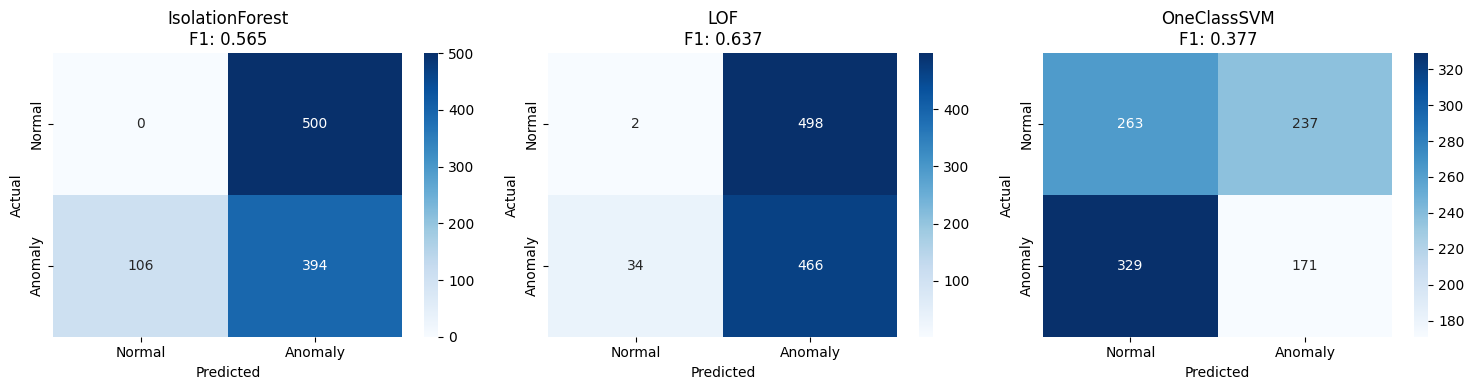

✓ Saved confusion matrices to: confusion_matrices.png

DETAILED CLASSIFICATION REPORTS

IsolationForest Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       500
     Anomaly       0.44      0.79      0.57       500

    accuracy                           0.39      1000
   macro avg       0.22      0.39      0.28      1000
weighted avg       0.22      0.39      0.28      1000


LOF Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.06      0.00      0.01       500
     Anomaly       0.48      0.93      0.64       500

    accuracy                           0.47      1000
   macro avg       0.27      0.47      0.32      1000
weighted avg       0.27      0.47      0.32      1000


OneClassSVM Classification Report:
---------------------------------

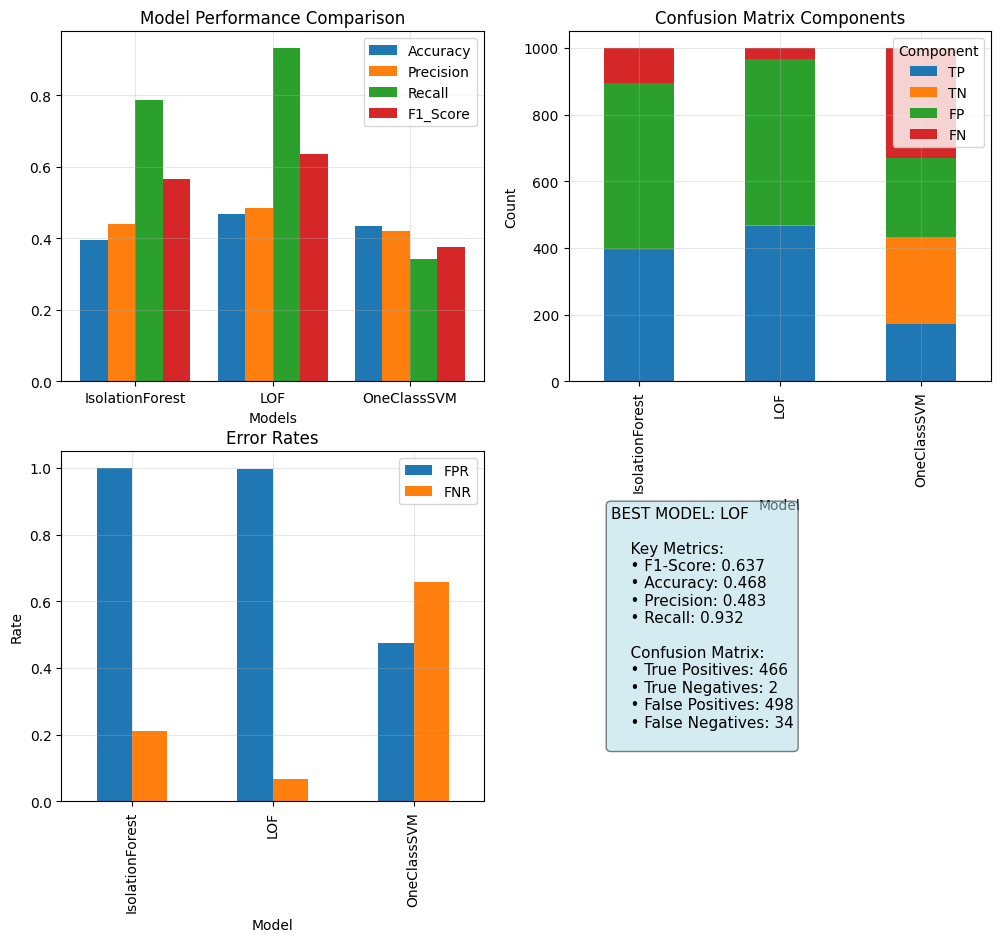

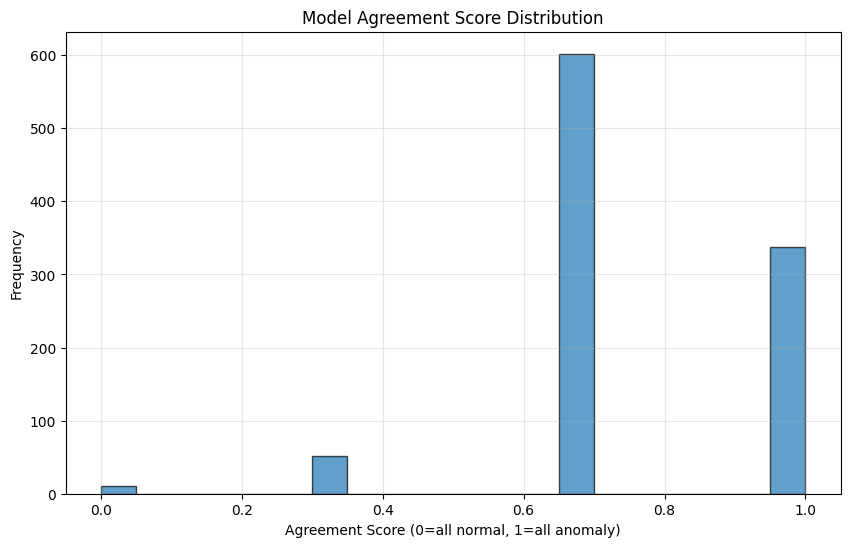

✓ Saved agreement distribution to: agreement_distribution.png

SAVING FINAL RESULTS

✓ Evaluation complete!

Generated files:
1. test_results_comprehensive.csv - Complete results with predictions
2. model_comparison_detailed.csv - Detailed metrics for all models
3. confusion_matrices.png - Visual confusion matrices
4. model_performance_comparison.png - Performance comparison
5. classification_report_*.txt - Individual classification reports
6. agreement_distribution.png - Model agreement visualization
7. model_comparison_basic.csv - Basic anomaly statistics

FINAL SUMMARY

Top Performing Model (by F1-Score):
  Model: LOF
  F1-Score: 0.637
  Precision: 0.483
  Recall: 0.932
  Anomalies detected: 964
  True anomalies found: 466/500

⚠ GOOD: Model performance is acceptable but could be improved
  Recommendation: Too many false positives. Consider tuning thresholds.

Total tenders analyzed: 1000
Actual anomaly rate in data: 50.0%


In [10]:
# @title New Latest Testing Module
"""
TEJAS – TENDER ANOMALY DETECTION
COMPLETE MODEL TESTING WITH EVALUATION

This script:
1. Loads trained models
2. Rebuilds test features EXACTLY like training
3. Runs predictions
4. Evaluates against ground truth with metrics
5. Generates confusion matrices and reports
"""

import pickle
import joblib
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# =========================
# CONFIG
# =========================
TEST_DATA = "cleaned_tenders.csv"
FEATURES_FILE = "features.pkl"
MODEL_DIR = ""

MODELS = {
    "IsolationForest": "drive/MyDrive/models/isolation_forest.pkl",
    "LOF": "drive/MyDrive/models/lof.pkl",
    "OneClassSVM": "drive/MyDrive/models/one_class_svm.pkl"
}

# =========================
# 1. LOAD FEATURE METADATA
# =========================
print("\n[1/7] Loading feature metadata...")

with open(FEATURES_FILE, "rb") as f:
    feature_data = pickle.load(f)

EMBED_COLS = feature_data["embedding_columns"]
NUM_COLS = feature_data["numerical_columns"]
FEATURE_ORDER = EMBED_COLS + NUM_COLS
SCALER = feature_data["scaler"]
EMBED_MODEL_NAME = feature_data["model_name"]

print(f"✓ Expected features: {len(FEATURE_ORDER)}")

# =========================
# 2. LOAD TEST DATA WITH GROUND TRUTH
# =========================
print("\n[2/7] Loading test dataset with ground truth...")
df = pd.read_csv(TEST_DATA)

# Check for ground truth labels
ground_truth_col = None
for col in ['Is_Anomaly', 'Ground_Truth_Anomaly', 'Anomaly_Label']:
    if col in df.columns:
        ground_truth_col = col
        break

if ground_truth_col:
    y_true = df[ground_truth_col].astype(int)
    print(f"✓ Found ground truth in column: '{ground_truth_col}'")
    print(f"  Anomalies: {y_true.sum()} ({y_true.mean()*100:.1f}%)")
    print(f"  Normal: {len(y_true) - y_true.sum()}")
else:
    print("⚠ No ground truth labels found! Only basic statistics will be calculated.")
    print("  Available columns:", df.columns.tolist())
    y_true = None

print(f"✓ Loaded {len(df)} test tenders")

# =========================
# 3. TEXT EMBEDDINGS
# =========================
print("\n[3/7] Generating text embeddings...")
embedder = SentenceTransformer(EMBED_MODEL_NAME)

embeddings = embedder.encode(
    df["Combined_Text"].fillna("").tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True
)

df_embeddings = pd.DataFrame(
    embeddings,
    columns=EMBED_COLS
)

# =========================
# 4. NUMERICAL FEATURES
# =========================
print("\n[4/7] Rebuilding numerical features...")
num = pd.DataFrame()

# Handle missing values properly
num["Estimated_Value"] = df["Estimated_Value_Numeric"].fillna(
    df["Estimated_Value_Numeric"].median()
)
num["Log_Estimated_Value"] = df["Log_Estimated_Value"].fillna(0)

num["Value_Z_Score_CPV"] = df.groupby("CPV_Level_2")["Estimated_Value_Numeric"]\
    .transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)\
    .fillna(0)

num["Title_Length"] = df["Title_Length"].fillna(0)
num["Description_Length"] = df["Description_Length"].fillna(0)
num["Word_Count"] = df["Word_Count"].fillna(0)
num["Combined_Text_Length"] = df["Combined_Text_Length"].fillna(0)

num["Authority_Frequency"] = df["Authority_Frequency"].fillna(1)
num["CPV_Frequency"] = df["CPV_Frequency"].fillna(1)

num["CPV_Level_2"] = df["CPV_Level_2"].fillna(0)
num["CPV_Level_4"] = df["CPV_Level_4"].fillna(0)

num["Value_Per_Word"] = num["Estimated_Value"] / (num["Word_Count"] + 1)
num["Complexity_Ratio"] = num["Description_Length"] / (num["Word_Count"] + 1)

# Scale using TRAINED scaler
num_scaled = pd.DataFrame(
    SCALER.transform(num),
    columns=NUM_COLS
)

# =========================
# 5. FEATURE MATRIX
# =========================
print("\n[5/7] Building final feature matrix...")
X_test = pd.concat([df_embeddings, num_scaled], axis=1)
X_test = X_test[FEATURE_ORDER]

print(f"✓ Feature matrix shape: {X_test.shape}")

# =========================
# 6. MODEL PREDICTIONS
# =========================
print("\n[6/7] Running model predictions...\n")

results = {}
predictions = {}
detailed_metrics = {}

for name, file in MODELS.items():
    try:
        print(f"Processing {name}...")
        model = joblib.load(MODEL_DIR + file)
        preds_raw = model.predict(X_test)

        # Convert to binary (0=normal, 1=anomaly)
        if hasattr(model, 'predict'):  # Standard sklearn models
            preds_binary = (preds_raw == -1).astype(int)
        else:
            # Handle other model types
            preds_binary = preds_raw.astype(int)

        predictions[name] = preds_binary

        # Basic statistics
        results[name] = {
            "Total_Anomalies": int(preds_binary.sum()),
            "Anomaly_Rate_%": round(preds_binary.mean() * 100, 2)
        }

        # If ground truth available, calculate detailed metrics
        if y_true is not None:
            tn, fp, fn, tp = confusion_matrix(y_true, preds_binary).ravel()

            detailed_metrics[name] = {
                "Accuracy": accuracy_score(y_true, preds_binary),
                "Precision": precision_score(y_true, preds_binary, zero_division=0),
                "Recall": recall_score(y_true, preds_binary, zero_division=0),
                "F1_Score": f1_score(y_true, preds_binary, zero_division=0),
                "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
                "FPR": fp / (fp + tn) if (fp + tn) > 0 else 0,
                "FNR": fn / (fn + tp) if (fn + tp) > 0 else 0,
                "MCC": matthews_corrcoef(y_true, preds_binary),
                "TP": int(tp),
                "TN": int(tn),
                "FP": int(fp),
                "FN": int(fn)
            }

            print(f"  ✓ Anomalies detected: {preds_binary.sum()} (True: {y_true.sum()})")
            print(f"    Accuracy: {detailed_metrics[name]['Accuracy']:.3f}, F1: {detailed_metrics[name]['F1_Score']:.3f}")
        else:
            print(f"  ✓ Anomalies detected: {preds_binary.sum()}")

    except Exception as e:
        print(f"  ✗ Error with {name}: {e}")
        continue

# =========================
# 7. EVALUATION AND VISUALIZATION
# =========================
print("\n[7/7] Generating evaluation reports...")

# Basic results
if results:
    results_df = pd.DataFrame(results).T
    print("\n" + "="*80)
    print("MODEL COMPARISON - BASIC STATISTICS")
    print("="*80)
    print(results_df)

    # Save basic results
    results_df.to_csv("model_comparison_basic.csv")

# Detailed metrics
if detailed_metrics:
    metrics_df = pd.DataFrame(detailed_metrics).T
    print("\n" + "="*80)
    print("MODEL COMPARISON - DETAILED METRICS")
    print("="*80)
    print(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity', 'MCC']].round(3))

    # Save detailed metrics
    metrics_df.to_csv("model_comparison_detailed.csv")

    # =========================
    # CONFUSION MATRICES
    # =========================
    print("\n" + "="*80)
    print("GENERATING CONFUSION MATRICES")
    print("="*80)

    # Create confusion matrices plot
    n_models = len(detailed_metrics)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]

    for idx, (model_name, metrics) in enumerate(detailed_metrics.items()):
        cm = np.array([[metrics['TN'], metrics['FP']],
                       [metrics['FN'], metrics['TP']]])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Anomaly'],
                   yticklabels=['Normal', 'Anomaly'],
                   ax=axes[idx])

        axes[idx].set_title(f'{model_name}\nF1: {metrics["F1_Score"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved confusion matrices to: confusion_matrices.png")

    # =========================
    # MODEL COMPARISON VISUALIZATION
    # =========================
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    # Flatten the 2D axes array to 1D for easy indexing
    axes_flat = axes.flatten()

    # 1. Bar chart of key metrics
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    x = np.arange(len(detailed_metrics))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        values = [detailed_metrics[m][metric] for m in detailed_metrics.keys()]
        # Use axes_flat[0] instead of axes[0]
        axes_flat[0].bar(x + width*i, values, width, label=metric)

    axes_flat[0].set_xlabel('Models')
    axes_flat[0].set_title('Model Performance Comparison')
    axes_flat[0].set_xticks(x + width*1.5)
    axes_flat[0].set_xticklabels(list(detailed_metrics.keys()))
    axes_flat[0].legend()
    axes_flat[0].grid(True, alpha=0.3)

    # 2. Confusion matrix components (Now use axes_flat[1])
    confusion_data = pd.DataFrame({
        'Model': list(detailed_metrics.keys()),
        'TP': [m['TP'] for m in detailed_metrics.values()],
        'TN': [m['TN'] for m in detailed_metrics.values()],
        'FP': [m['FP'] for m in detailed_metrics.values()],
        'FN': [m['FN'] for m in detailed_metrics.values()]
    })
    confusion_data.set_index('Model', inplace=True)
    confusion_data.plot(kind='bar', stacked=True, ax=axes_flat[1])  # Changed to axes_flat[1]
    axes_flat[1].set_title('Confusion Matrix Components')
    axes_flat[1].set_ylabel('Count')
    axes_flat[1].legend(title='Component')
    axes_flat[1].grid(True, alpha=0.3)

    # 3. Error rates (Now use axes_flat[2])
    error_data = pd.DataFrame({
        'Model': list(detailed_metrics.keys()),
        'FPR': [m['FPR'] for m in detailed_metrics.values()],
        'FNR': [m['FNR'] for m in detailed_metrics.values()]
    })
    error_data.set_index('Model', inplace=True)
    error_data.plot(kind='bar', ax=axes_flat[2])  # Changed to axes_flat[2]
    axes_flat[2].set_title('Error Rates')
    axes_flat[2].set_ylabel('Rate')
    axes_flat[2].grid(True, alpha=0.3)

    # 4. Best model summary (Now use axes_flat[3])
    best_model = max(detailed_metrics.items(), key=lambda x: x[1]['F1_Score'])
    axes_flat[3].axis('off')
    summary_text = f"""BEST MODEL: {best_model[0]}

    Key Metrics:
    • F1-Score: {best_model[1]['F1_Score']:.3f}
    • Accuracy: {best_model[1]['Accuracy']:.3f}
    • Precision: {best_model[1]['Precision']:.3f}
    • Recall: {best_model[1]['Recall']:.3f}

    Confusion Matrix:
    • True Positives: {best_model[1]['TP']}
    • True Negatives: {best_model[1]['TN']}
    • False Positives: {best_model[1]['FP']}
    • False Negatives: {best_model[1]['FN']}
    """
    axes_flat[3].text(0.1, 0.5, summary_text, fontsize=11,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    # =========================
    # CLASSIFICATION REPORTS
    # =========================
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORTS")
    print("="*80)

    for model_name in predictions.keys():
        if model_name in detailed_metrics:
            print(f"\n{model_name} Classification Report:")
            print("-" * 60)
            report = classification_report(y_true, predictions[model_name],
                                         target_names=['Normal', 'Anomaly'])
            print(report)

            # Save individual report
            with open(f'classification_report_{model_name}.txt', 'w') as f:
                f.write(f"Classification Report: {model_name}\n")
                f.write("="*60 + "\n")
                f.write(report)
                f.write(f"\nConfusion Matrix:\n")
                f.write(f"True Positives: {detailed_metrics[model_name]['TP']}\n")
                f.write(f"True Negatives: {detailed_metrics[model_name]['TN']}\n")
                f.write(f"False Positives: {detailed_metrics[model_name]['FP']}\n")
                f.write(f"False Negatives: {detailed_metrics[model_name]['FN']}\n")

# =========================
# AGREEMENT ANALYSIS
# =========================
print("\n" + "="*80)
print("MODEL AGREEMENT ANALYSIS")
print("="*80)

if len(predictions) > 1:
    pred_matrix = np.column_stack(list(predictions.values()))
    df["Anomaly_Agreement_Score"] = pred_matrix.mean(axis=1)

    print("\nAgreement Score Distribution:")
    print(df["Anomaly_Agreement_Score"].value_counts().sort_index())

    # Agreement visualization
    plt.figure(figsize=(10, 6))
    df["Anomaly_Agreement_Score"].hist(bins=20, alpha=0.7, edgecolor='black')
    plt.title('Model Agreement Score Distribution')
    plt.xlabel('Agreement Score (0=all normal, 1=all anomaly)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig('agreement_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved agreement distribution to: agreement_distribution.png")

# =========================
# SAVE FINAL RESULTS
# =========================
print("\n" + "="*80)
print("SAVING FINAL RESULTS")
print("="*80)

# Add predictions to dataframe
for model_name, preds in predictions.items():
    df[f'{model_name}_Prediction'] = preds

# Save comprehensive results
df.to_csv("test_results_comprehensive.csv", index=False)

print("\n✓ Evaluation complete!")
print("\nGenerated files:")
print("1. test_results_comprehensive.csv - Complete results with predictions")
if detailed_metrics:
    print("2. model_comparison_detailed.csv - Detailed metrics for all models")
    print("3. confusion_matrices.png - Visual confusion matrices")
    print("4. model_performance_comparison.png - Performance comparison")
    print("5. classification_report_*.txt - Individual classification reports")
if len(predictions) > 1:
    print("6. agreement_distribution.png - Model agreement visualization")
print("7. model_comparison_basic.csv - Basic anomaly statistics")

# =========================
# FINAL SUMMARY
# =========================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

if detailed_metrics:
    print("\nTop Performing Model (by F1-Score):")
    best_model_name = max(detailed_metrics, key=lambda x: detailed_metrics[x]['F1_Score'])
    best_metrics = detailed_metrics[best_model_name]
    print(f"  Model: {best_model_name}")
    print(f"  F1-Score: {best_metrics['F1_Score']:.3f}")
    print(f"  Precision: {best_metrics['Precision']:.3f}")
    print(f"  Recall: {best_metrics['Recall']:.3f}")
    print(f"  Anomalies detected: {best_metrics['TP'] + best_metrics['FP']}")
    print(f"  True anomalies found: {best_metrics['TP']}/{y_true.sum()}")

    # Recommendation based on performance
    if best_metrics['F1_Score'] > 0.8:
        print("\n✅ EXCELLENT: Model is performing very well!")
    elif best_metrics['F1_Score'] > 0.6:
        print("\n⚠ GOOD: Model performance is acceptable but could be improved")
        if best_metrics['Precision'] < 0.5:
            print("  Recommendation: Too many false positives. Consider tuning thresholds.")
        if best_metrics['Recall'] < 0.5:
            print("  Recommendation: Missing many anomalies. Consider making model more sensitive.")
    else:
        print("\n❌ NEEDS IMPROVEMENT: Model performance is poor")
        print("  Recommendations:")
        print("  1. Check feature engineering")
        print("  2. Review training data quality")
        print("  3. Try different anomaly detection algorithms")
        print("  4. Consider ensemble methods")

print(f"\nTotal tenders analyzed: {len(df)}")
if y_true is not None:
    print(f"Actual anomaly rate in data: {y_true.mean()*100:.1f}%")
print("="*80)

In [5]:
import pandas as pd

df = pd.read_csv("/tender_anomaly_dataset.csv")
df.to_excel("/tender_anomaly_dataset.xlsx", index=False)
